<a href="https://colab.research.google.com/github/yasinunsal/INM706/blob/main/FasterRCNN_112_112_faster_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [5]:
%cd /content/drive/MyDrive/Colab\ Notebooks
!ls


/content/drive/MyDrive/Colab Notebooks
'Copy of FasterRCNN_112_112_mobilenet_v3_large_320_fpn.ipynb'
'Copy of INM707-Lab7-REINFORCE.ipynb'
'Copy of INM707-Lab8-DoubleDQN.ipynb'
'Copy of INM707-Lab9-AC-PPO.ipynb'
 FasterRCNN_112_112_faster_weights_adam.ipynb
 FasterRCNN_112_112_faster_weights.ipynb
 FasterRCNN_config.ipynb
 FasterRCNN.ipynb
 FrCNN_config.ipynb
 fruit-images-for-object-detection
 INFERECE_INM705Lab3_object_dection.ipynb
 Inference_Load_Checkpoints.ipynb
 INM705
'INM705_lab1_showcase (1).ipynb'
 INM705_lab1_showcase.ipynb
'INM705_W7 - Graph Networks.ipynb'
 INM706_CW_from_PyCharm.ipynb
 INM706_W7_Bert
 INM707-Lab6
 Lab4_FCN_MASK_RCNN_Inference.ipynb
'Load of FasterRCNN checkpoint.ipynb'
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb


In [3]:
!pip install -q torch_snippets
!pip install wandb -qU
from torch_snippets import *
import torch
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
import numpy as np
import wandb
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 81.7 MB/s eta 

cuda

In [6]:
# get parameters from config file
import yaml

def read_settings(config_path):
    with open(config_path, 'r') as file:
        settings = yaml.safe_load(file)
    return settings


# Read settings from the YAML file
config_path = 'fruit-images-for-object-detection/config.yaml'
settings = read_settings(config_path)

path_settings = settings.get('path_settings', {})
model_settings = settings.get('model', {})
train_settings = settings.get('train', {})


# Assign Parameters
root = path_settings['train_root']
val_root = path_settings['val_root']

epochs = train_settings['epochs']
batch_size_train = train_settings['batch_size_train']
batch_size_val = train_settings['batch_size_val']
learning_rate = train_settings['learning_rate']
weight_decay = train_settings['weight_decay']

# Hyperparameters
optimizer_pars = {'lr': learning_rate, 'weight_decay': weight_decay }


checkpoint_file = path_settings['checkpoint_root'] + f"{model_settings['backbone']}_{model_settings['optimizer']}_lr_{learning_rate}_CKPT.pth"
print(checkpoint_file)

fruit-images-for-object-detection/checkpoints/RESNET_SGD_lr_1e-05_CKPT.pth

In [7]:
def save_checkpoint(epoch, model, model_name, optimizer, optimizer_name):
    ckpt = {'epoch': epoch, 'model_weights': model.state_dict(), 'optimizer_state': optimizer.state_dict()}
    checkpoint_path = path_settings['checkpoint_root'] + f"{model_name}_OPT_{optimizer_name}_CKPT.pth"
    torch.save(ckpt, checkpoint_path)


In [8]:
# we have four labels
labels = ['background', 'orange', 'apple', 'banana']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)

In [9]:

log_name = f"FRCNN_{model_settings['backbone']}_{model_settings['optimizer']}_lr_{optimizer_pars['lr']}_weight_decay_{optimizer_pars['weight_decay']}"
wandb.login()
wandb.init(project='INM706_CW', name=log_name )

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: berrinulus. Use `wandb login --relogin` to force relogin


In [10]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.to(device).float()

class FruitsDataset(Dataset):
    def __init__(self, root=root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.img_paths = sorted(Glob(self.root + '/*.jpg'))
        self.xlm_paths = sorted(Glob(self.root + '/*.xml'))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        w = train_settings['image_size']
        h = train_settings['image_size']
        img_path = self.img_paths[idx]
        xlm_path = self.xlm_paths[idx]
        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        img = np.array(img.resize((w, h), resample=Image.BILINEAR))/255.
        xlm = et.parse(xlm_path)
        objects = xlm.findall('object')
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(label)
            XMin = float(obj.find('bndbox').find('xmin').text)
            YMin = float(obj.find('bndbox').find('ymin').text)
            XMax = float(obj.find('bndbox').find('xmax').text)
            YMax = float(obj.find('bndbox').find('ymax').text)
            bbox = [XMin / W, YMin / H, XMax / W, YMax / H]
            bbox = (bbox * np.array([w, h, w, h])).astype(np.int16).tolist()
            boxes.append(bbox)
        target = {}
        target['labels'] = torch.tensor([label2targets[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()
        img = preprocess_img(img)
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))


tr_ds = FruitsDataset()
tr_dl = DataLoader(tr_ds, batch_size=batch_size_train, shuffle=True, collate_fn=tr_ds.collate_fn)

val_ds = FruitsDataset(root=val_root)
val_dl = DataLoader(val_ds, batch_size=batch_size_val, shuffle=True, collate_fn=val_ds.collate_fn)


In [11]:
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights as faster_weights

def get_model():
    if model_settings['backbone'] == "RESNET":
      model = models.detection.fasterrcnn_resnet50_fpn(weights=faster_weights.DEFAULT)
    elif model_settings['backbone'] == "MOBILENET":
      model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, progress=True)


    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model



# test the model
imgs, targets = next(iter(tr_dl))
imgs = list(img.to(device) for img in imgs)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model = get_model().to(device)
model(imgs, targets)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 73.5MB/s]


{'loss_classifier': tensor(1.7228, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1837, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0013, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)}

In [12]:
model = get_model().to(device)
if model_settings['optimizer'] == 'SGD':
  optim = torch.optim.SGD(model.parameters(), **optimizer_pars)
else:
  optim = torch.optim.Adam(model.parameters(), **optimizer_pars)

def train_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optim.step()


    return loss, losses

@torch.no_grad()
def validate_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses





EPOCH: 0.017  trn_loss: 1.719  trn_loc_loss: 1.454  trn_regr_loss: 0.258  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.006  (1.18s - 7080.85s remaining)
EPOCH: 0.033  trn_loss: 1.742  trn_loc_loss: 1.424  trn_regr_loss: 0.305  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.006  (1.89s - 5677.96s remaining)
EPOCH: 0.050  trn_loss: 1.752  trn_loc_loss: 1.479  trn_regr_loss: 0.261  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.005  (2.91s - 5807.15s remaining)
EPOCH: 0.067  trn_loss: 2.096  trn_loc_loss: 1.476  trn_regr_loss: 0.598  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.014  (3.65s - 5464.05s remaining)
EPOCH: 0.083  trn_loss: 1.910  trn_loc_loss: 1.476  trn_regr_loss: 0.426  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.005  (4.37s - 5243.38s remaining)
EPOCH: 0.100  trn_loss: 1.820  trn_loc_loss: 1.442  trn_regr_loss: 0.364  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.009  (5.16s - 5151.17s remaining)
EPOCH: 0.117  trn_loss: 1.698  trn_loc_l

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH: 0.683  trn_loss: 1.627  trn_loc_loss: 1.357  trn_regr_loss: 0.266  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (31.91s - 4638.17s remaining)
EPOCH: 0.700  trn_loss: 1.956  trn_loc_loss: 1.340  trn_regr_loss: 0.584  trn_loss_objectness: 0.020  trn_loss_rpn_box_reg: 0.011  (32.69s - 4637.81s remaining)
EPOCH: 0.717  trn_loss: 1.515  trn_loc_loss: 1.299  trn_regr_loss: 0.203  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.008  (33.42s - 4629.87s remaining)
EPOCH: 0.733  trn_loss: 1.540  trn_loc_loss: 1.309  trn_regr_loss: 0.221  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.004  (34.16s - 4624.26s remaining)
EPOCH: 0.750  trn_loss: 1.521  trn_loc_loss: 1.339  trn_regr_loss: 0.171  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.003  (34.90s - 4618.32s remaining)
EPOCH: 0.767  trn_loss: 1.684  trn_loc_loss: 1.297  trn_regr_loss: 0.373  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.003  (35.61s - 4609.02s remaining)
EPOCH: 0.783  trn_loss: 1.492  trn

Loss=1.6847 in Epoch=0

EPOCH: 1.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 1.685  trn_loc_loss: 1.364  trn_regr_loss: 0.308  (46.91s - 4643.79s remaining)
EPOCH: 1.017  trn_loss: 1.490  trn_loc_loss: 1.249  trn_regr_loss: 0.234  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.004  (47.66s - 4640.12s remaining)
EPOCH: 1.033  trn_loss: 1.429  trn_loc_loss: 1.258  trn_regr_loss: 0.162  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.006  (48.39s - 4634.89s remaining)
EPOCH: 1.050  trn_loss: 1.410  trn_loc_loss: 1.267  trn_regr_loss: 0.137  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (49.15s - 4631.37s remaining)
EPOCH: 1.067  trn_loss: 1.439  trn_loc_loss: 1.209  trn_regr_loss: 0.222  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.003  (49.92s - 4629.81s remaining)
EPOCH: 1.083  trn_loss: 1.628  trn_loc_loss: 1.225  trn_regr_loss: 0.391  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.009  (50.65s - 4625.17s remaining)
EPOCH: 1.100  trn_loss: 1.822  trn

Loss=1.5151 in Epoch=1

EPOCH: 2.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 1.521  trn_loc_loss: 1.196  trn_regr_loss: 0.311  (93.75s - 4593.64s remaining)
EPOCH: 2.017  trn_loss: 1.367  trn_loc_loss: 1.109  trn_regr_loss: 0.246  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.005  (94.64s - 4598.10s remaining)
EPOCH: 2.033  trn_loss: 1.363  trn_loc_loss: 1.100  trn_regr_loss: 0.253  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.005  (95.42s - 4597.61s remaining)
EPOCH: 2.050  trn_loss: 1.373  trn_loc_loss: 1.109  trn_regr_loss: 0.250  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.003  (96.59s - 4615.04s remaining)
EPOCH: 2.067  trn_loss: 1.510  trn_loc_loss: 1.183  trn_regr_loss: 0.313  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.009  (97.35s - 4613.21s remaining)
EPOCH: 2.083  trn_loss: 1.334  trn_loc_loss: 1.091  trn_regr_loss: 0.232  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.005  (98.12s - 4611.79s remaining)
EPOCH: 2.100  trn_loss: 1.677  trn

Loss=1.3733 in Epoch=2

EPOCH: 3.000  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.007  trn_loss: 1.374  trn_loc_loss: 1.055  trn_regr_loss: 0.306  (142.66s - 4612.68s remaining)
EPOCH: 3.017  trn_loss: 1.672  trn_loc_loss: 1.085  trn_regr_loss: 0.554  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.022  (143.54s - 4614.54s remaining)
EPOCH: 3.033  trn_loss: 1.217  trn_loc_loss: 0.968  trn_regr_loss: 0.246  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (144.32s - 4613.44s remaining)
EPOCH: 3.050  trn_loss: 1.335  trn_loc_loss: 0.986  trn_regr_loss: 0.336  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  (145.07s - 4611.32s remaining)
EPOCH: 3.067  trn_loss: 1.176  trn_loc_loss: 0.966  trn_regr_loss: 0.195  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.006  (145.90s - 4611.73s remaining)
EPOCH: 3.083  trn_loss: 1.603  trn_loc_loss: 1.075  trn_regr_loss: 0.507  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.012  (146.69s - 4610.70s remaining)
EPOCH: 3.100  trn_loss: 1.30

Loss=1.2548 in Epoch=3

EPOCH: 4.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 1.255  trn_loc_loss: 0.935  trn_regr_loss: 0.307  (190.59s - 4574.08s remaining)
EPOCH: 4.017  trn_loss: 1.258  trn_loc_loss: 0.874  trn_regr_loss: 0.356  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.016  (191.84s - 4584.29s remaining)
EPOCH: 4.033  trn_loss: 1.457  trn_loc_loss: 0.918  trn_regr_loss: 0.514  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.016  (192.63s - 4583.34s remaining)
EPOCH: 4.050  trn_loss: 1.225  trn_loc_loss: 0.883  trn_regr_loss: 0.297  trn_loss_objectness: 0.031  trn_loss_rpn_box_reg: 0.014  (193.41s - 4582.04s remaining)
EPOCH: 4.067  trn_loss: 1.198  trn_loc_loss: 0.888  trn_regr_loss: 0.302  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.005  (194.19s - 4580.93s remaining)
EPOCH: 4.083  trn_loss: 1.454  trn_loc_loss: 0.949  trn_regr_loss: 0.484  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.009  (194.97s - 4579.78s remaining)
EPOCH: 4.100  trn_loss: 0.99

Loss=1.1559 in Epoch=4

EPOCH: 5.000  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.007  trn_loss: 1.150  trn_loc_loss: 0.834  trn_regr_loss: 0.302  (239.18s - 4544.37s remaining)
EPOCH: 5.017  trn_loss: 1.283  trn_loc_loss: 0.838  trn_regr_loss: 0.428  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.010  (240.03s - 4544.64s remaining)
EPOCH: 5.033  trn_loss: 0.924  trn_loc_loss: 0.704  trn_regr_loss: 0.204  trn_loss_objectness: 0.013  trn_loss_rpn_box_reg: 0.003  (241.21s - 4551.02s remaining)
EPOCH: 5.050  trn_loss: 1.055  trn_loc_loss: 0.774  trn_regr_loss: 0.269  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.004  (241.98s - 4549.76s remaining)
EPOCH: 5.067  trn_loss: 0.905  trn_loc_loss: 0.716  trn_regr_loss: 0.180  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.005  (242.76s - 4548.48s remaining)
EPOCH: 5.083  trn_loss: 1.160  trn_loc_loss: 0.812  trn_regr_loss: 0.320  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.019  (243.51s - 4546.90s remaining)
EPOCH: 5.100  trn_loss: 0.90

Loss=1.0723 in Epoch=5

EPOCH: 6.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 1.082  trn_loc_loss: 0.754  trn_regr_loss: 0.315  (287.63s - 4506.19s remaining)
EPOCH: 6.017  trn_loss: 1.191  trn_loc_loss: 0.755  trn_regr_loss: 0.423  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.004  (288.48s - 4506.23s remaining)
EPOCH: 6.033  trn_loss: 0.822  trn_loc_loss: 0.663  trn_regr_loss: 0.153  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.005  (289.26s - 4505.04s remaining)
EPOCH: 6.050  trn_loss: 0.942  trn_loc_loss: 0.687  trn_regr_loss: 0.249  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.002  (290.45s - 4510.41s remaining)
EPOCH: 6.067  trn_loss: 1.269  trn_loc_loss: 0.778  trn_regr_loss: 0.474  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.007  (291.25s - 4509.51s remaining)
EPOCH: 6.083  trn_loss: 1.192  trn_loc_loss: 0.707  trn_regr_loss: 0.470  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.006  (292.06s - 4508.87s remaining)
EPOCH: 6.100  trn_loss: 1.07

Loss=1.0028 in Epoch=6

EPOCH: 7.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 1.002  trn_loc_loss: 0.684  trn_regr_loss: 0.306  (336.11s - 4465.52s remaining)
EPOCH: 7.017  trn_loss: 1.003  trn_loc_loss: 0.626  trn_regr_loss: 0.361  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.006  (336.99s - 4465.70s remaining)
EPOCH: 7.033  trn_loss: 0.886  trn_loc_loss: 0.655  trn_regr_loss: 0.220  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.008  (337.81s - 4465.19s remaining)
EPOCH: 7.050  trn_loss: 1.093  trn_loc_loss: 0.671  trn_regr_loss: 0.404  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.009  (338.60s - 4464.18s remaining)
EPOCH: 7.067  trn_loss: 1.008  trn_loc_loss: 0.665  trn_regr_loss: 0.324  trn_loss_objectness: 0.016  trn_loss_rpn_box_reg: 0.003  (339.40s - 4463.37s remaining)
EPOCH: 7.083  trn_loss: 0.910  trn_loc_loss: 0.658  trn_regr_loss: 0.240  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.010  (340.58s - 4467.66s remaining)
EPOCH: 7.100  trn_loss: 0.92

Loss=0.9466 in Epoch=7

EPOCH: 8.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.949  trn_loc_loss: 0.628  trn_regr_loss: 0.308  (384.62s - 4423.13s remaining)
EPOCH: 8.017  trn_loss: 0.904  trn_loc_loss: 0.606  trn_regr_loss: 0.279  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.008  (385.51s - 4423.32s remaining)
EPOCH: 8.033  trn_loss: 0.766  trn_loc_loss: 0.546  trn_regr_loss: 0.209  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.005  (386.76s - 4427.72s remaining)
EPOCH: 8.050  trn_loss: 1.188  trn_loc_loss: 0.682  trn_regr_loss: 0.475  trn_loss_objectness: 0.016  trn_loss_rpn_box_reg: 0.014  (387.56s - 4426.90s remaining)
EPOCH: 8.067  trn_loss: 0.798  trn_loc_loss: 0.556  trn_regr_loss: 0.232  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.008  (388.34s - 4425.82s remaining)
EPOCH: 8.083  trn_loss: 1.230  trn_loc_loss: 0.689  trn_regr_loss: 0.525  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.007  (389.11s - 4424.66s remaining)
EPOCH: 8.100  trn_loss: 0.75

Loss=0.9005 in Epoch=8

EPOCH: 9.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.904  trn_loc_loss: 0.583  trn_regr_loss: 0.309  (433.14s - 4379.51s remaining)
EPOCH: 9.017  trn_loss: 0.811  trn_loc_loss: 0.557  trn_regr_loss: 0.245  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.005  (434.03s - 4379.57s remaining)
EPOCH: 9.033  trn_loss: 0.689  trn_loc_loss: 0.485  trn_regr_loss: 0.191  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.003  (434.79s - 4378.43s remaining)
EPOCH: 9.050  trn_loss: 0.800  trn_loc_loss: 0.516  trn_regr_loss: 0.279  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.004  (435.56s - 4377.27s remaining)
EPOCH: 9.067  trn_loss: 0.749  trn_loc_loss: 0.486  trn_regr_loss: 0.257  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.004  (436.34s - 4376.18s remaining)
EPOCH: 9.083  trn_loss: 0.961  trn_loc_loss: 0.584  trn_regr_loss: 0.361  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.010  (437.11s - 4375.15s remaining)
EPOCH: 9.100  trn_loss: 1.08

Loss=0.8613 in Epoch=9

EPOCH: 10.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.858  trn_loc_loss: 0.540  trn_regr_loss: 0.305  (481.34s - 4332.09s remaining)
EPOCH: 10.017  trn_loss: 1.019  trn_loc_loss: 0.576  trn_regr_loss: 0.435  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.006  (482.64s - 4335.77s remaining)
EPOCH: 10.033  trn_loss: 0.901  trn_loc_loss: 0.553  trn_regr_loss: 0.330  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.013  (483.41s - 4334.66s remaining)
EPOCH: 10.050  trn_loss: 0.680  trn_loc_loss: 0.461  trn_regr_loss: 0.203  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.007  (484.19s - 4333.59s remaining)
EPOCH: 10.067  trn_loss: 0.825  trn_loc_loss: 0.544  trn_regr_loss: 0.269  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.008  (484.95s - 4332.43s remaining)
EPOCH: 10.083  trn_loss: 0.836  trn_loc_loss: 0.541  trn_regr_loss: 0.270  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.015  (485.73s - 4331.42s remaining)
EPOCH: 10.100  trn_los

Loss=0.8286 in Epoch=10

EPOCH: 11.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.828  trn_loc_loss: 0.509  trn_regr_loss: 0.305  (529.89s - 4287.31s remaining)
EPOCH: 11.017  trn_loss: 0.912  trn_loc_loss: 0.498  trn_regr_loss: 0.406  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.008  (530.76s - 4287.05s remaining)
EPOCH: 11.033  trn_loss: 0.692  trn_loc_loss: 0.446  trn_regr_loss: 0.240  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.005  (531.92s - 4289.15s remaining)
EPOCH: 11.050  trn_loss: 0.796  trn_loc_loss: 0.479  trn_regr_loss: 0.300  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.003  (532.71s - 4288.22s remaining)
EPOCH: 11.067  trn_loss: 0.623  trn_loc_loss: 0.427  trn_regr_loss: 0.178  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.004  (533.49s - 4287.18s remaining)
EPOCH: 11.083  trn_loss: 0.675  trn_loc_loss: 0.455  trn_regr_loss: 0.207  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.009  (534.30s - 4286.46s remaining)
EPOCH: 11.100  trn_los

Loss=0.8001 in Epoch=11

EPOCH: 12.000  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.802  trn_loc_loss: 0.480  trn_regr_loss: 0.308  (578.38s - 4241.49s remaining)
EPOCH: 12.017  trn_loss: 0.661  trn_loc_loss: 0.406  trn_regr_loss: 0.245  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.008  (579.27s - 4241.29s remaining)
EPOCH: 12.033  trn_loss: 0.935  trn_loc_loss: 0.484  trn_regr_loss: 0.437  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.006  (580.04s - 4240.27s remaining)
EPOCH: 12.050  trn_loss: 0.511  trn_loc_loss: 0.364  trn_regr_loss: 0.140  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.003  (580.82s - 4239.27s remaining)
EPOCH: 12.067  trn_loss: 0.662  trn_loc_loss: 0.410  trn_regr_loss: 0.251  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (581.99s - 4241.14s remaining)
EPOCH: 12.083  trn_loss: 0.708  trn_loc_loss: 0.449  trn_regr_loss: 0.252  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.004  (582.87s - 4240.86s remaining)
EPOCH: 12.100  trn_los

Loss=0.7753 in Epoch=12

EPOCH: 13.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.776  trn_loc_loss: 0.457  trn_regr_loss: 0.306  (626.95s - 4195.72s remaining)
EPOCH: 13.017  trn_loss: 0.948  trn_loc_loss: 0.525  trn_regr_loss: 0.398  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.010  (627.96s - 4196.34s remaining)
EPOCH: 13.033  trn_loss: 0.574  trn_loc_loss: 0.400  trn_regr_loss: 0.169  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.004  (628.75s - 4195.42s remaining)
EPOCH: 13.050  trn_loss: 0.623  trn_loc_loss: 0.410  trn_regr_loss: 0.205  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.006  (629.58s - 4194.80s remaining)
EPOCH: 13.067  trn_loss: 0.709  trn_loc_loss: 0.412  trn_regr_loss: 0.286  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.004  (630.36s - 4193.79s remaining)
EPOCH: 13.083  trn_loss: 0.584  trn_loc_loss: 0.365  trn_regr_loss: 0.211  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.006  (631.13s - 4192.77s remaining)
EPOCH: 13.100  trn_los

Loss=0.7559 in Epoch=13

EPOCH: 14.000  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.755  trn_loc_loss: 0.435  trn_regr_loss: 0.306  (675.24s - 4147.90s remaining)
EPOCH: 14.017  trn_loss: 0.781  trn_loc_loss: 0.501  trn_regr_loss: 0.274  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.005  (676.11s - 4147.50s remaining)
EPOCH: 14.033  trn_loss: 0.675  trn_loc_loss: 0.400  trn_regr_loss: 0.263  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.002  (676.89s - 4146.58s remaining)
EPOCH: 14.050  trn_loss: 0.546  trn_loc_loss: 0.354  trn_regr_loss: 0.188  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (678.11s - 4148.30s remaining)
EPOCH: 14.067  trn_loss: 0.750  trn_loc_loss: 0.441  trn_regr_loss: 0.297  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.005  (678.88s - 4147.28s remaining)
EPOCH: 14.083  trn_loss: 0.651  trn_loc_loss: 0.384  trn_regr_loss: 0.256  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.006  (679.67s - 4146.37s remaining)
EPOCH: 14.100  trn_los

Loss=0.7367 in Epoch=14

EPOCH: 15.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.740  trn_loc_loss: 0.420  trn_regr_loss: 0.307  (723.73s - 4101.13s remaining)
EPOCH: 15.017  trn_loss: 1.022  trn_loc_loss: 0.511  trn_regr_loss: 0.462  trn_loss_objectness: 0.033  trn_loss_rpn_box_reg: 0.016  (724.63s - 4100.89s remaining)
EPOCH: 15.033  trn_loss: 0.731  trn_loc_loss: 0.397  trn_regr_loss: 0.327  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.006  (725.40s - 4099.88s remaining)
EPOCH: 15.050  trn_loss: 0.703  trn_loc_loss: 0.397  trn_regr_loss: 0.298  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.002  (726.19s - 4099.01s remaining)
EPOCH: 15.067  trn_loss: 0.627  trn_loc_loss: 0.385  trn_regr_loss: 0.229  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.007  (727.33s - 4100.11s remaining)
EPOCH: 15.083  trn_loss: 1.248  trn_loc_loss: 0.595  trn_regr_loss: 0.595  trn_loss_objectness: 0.027  trn_loss_rpn_box_reg: 0.031  (728.13s - 4099.23s remaining)
EPOCH: 15.100  trn_los

Loss=0.7233 in Epoch=15

EPOCH: 16.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.724  trn_loc_loss: 0.404  trn_regr_loss: 0.307  (772.28s - 4054.47s remaining)
EPOCH: 16.017  trn_loss: 0.745  trn_loc_loss: 0.409  trn_regr_loss: 0.319  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.008  (773.54s - 4056.08s remaining)
EPOCH: 16.033  trn_loss: 0.868  trn_loc_loss: 0.438  trn_regr_loss: 0.421  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.006  (774.32s - 4055.11s remaining)
EPOCH: 16.050  trn_loss: 0.618  trn_loc_loss: 0.376  trn_regr_loss: 0.235  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.002  (775.11s - 4054.22s remaining)
EPOCH: 16.067  trn_loss: 0.577  trn_loc_loss: 0.339  trn_regr_loss: 0.229  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.006  (775.87s - 4053.22s remaining)
EPOCH: 16.083  trn_loss: 0.809  trn_loc_loss: 0.419  trn_regr_loss: 0.366  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.016  (776.65s - 4052.27s remaining)
EPOCH: 16.100  trn_los

Loss=0.7107 in Epoch=16

EPOCH: 17.000  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.711  trn_loc_loss: 0.391  trn_regr_loss: 0.306  (820.84s - 4007.65s remaining)
EPOCH: 17.017  trn_loss: 0.716  trn_loc_loss: 0.383  trn_regr_loss: 0.325  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.007  (821.73s - 4007.26s remaining)
EPOCH: 17.033  trn_loss: 0.572  trn_loc_loss: 0.318  trn_regr_loss: 0.249  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.001  (822.54s - 4006.46s remaining)
EPOCH: 17.050  trn_loss: 0.547  trn_loc_loss: 0.345  trn_regr_loss: 0.193  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.002  (823.33s - 4005.60s remaining)
EPOCH: 17.067  trn_loss: 0.681  trn_loc_loss: 0.398  trn_regr_loss: 0.271  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  (824.14s - 4004.79s remaining)
EPOCH: 17.083  trn_loss: 0.670  trn_loc_loss: 0.382  trn_regr_loss: 0.271  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.009  (824.91s - 4003.82s remaining)
EPOCH: 17.100  trn_los

Loss=0.6986 in Epoch=17

EPOCH: 18.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.695  trn_loc_loss: 0.379  trn_regr_loss: 0.304  (869.09s - 3959.20s remaining)
EPOCH: 18.017  trn_loss: 0.915  trn_loc_loss: 0.445  trn_regr_loss: 0.460  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.008  (870.02s - 3958.95s remaining)
EPOCH: 18.033  trn_loss: 0.882  trn_loc_loss: 0.482  trn_regr_loss: 0.378  trn_loss_objectness: 0.015  trn_loss_rpn_box_reg: 0.007  (870.83s - 3958.17s remaining)
EPOCH: 18.050  trn_loss: 0.944  trn_loc_loss: 0.487  trn_regr_loss: 0.435  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.015  (871.63s - 3957.34s remaining)
EPOCH: 18.067  trn_loss: 0.500  trn_loc_loss: 0.318  trn_regr_loss: 0.179  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (872.42s - 3956.46s remaining)
EPOCH: 18.083  trn_loss: 0.587  trn_loc_loss: 0.317  trn_regr_loss: 0.265  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.004  (873.19s - 3955.51s remaining)
EPOCH: 18.100  trn_los

Loss=0.6879 in Epoch=18

EPOCH: 19.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.692  trn_loc_loss: 0.371  trn_regr_loss: 0.308  (917.20s - 3910.18s remaining)
EPOCH: 19.017  trn_loss: 0.520  trn_loc_loss: 0.306  trn_regr_loss: 0.208  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.005  (918.54s - 3911.65s remaining)
EPOCH: 19.033  trn_loss: 0.648  trn_loc_loss: 0.341  trn_regr_loss: 0.294  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  (919.32s - 3910.74s remaining)
EPOCH: 19.050  trn_loss: 0.565  trn_loc_loss: 0.319  trn_regr_loss: 0.239  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.004  (920.09s - 3909.77s remaining)
EPOCH: 19.067  trn_loss: 0.843  trn_loc_loss: 0.426  trn_regr_loss: 0.393  trn_loss_objectness: 0.016  trn_loss_rpn_box_reg: 0.009  (920.87s - 3908.85s remaining)
EPOCH: 19.083  trn_loss: 0.500  trn_loc_loss: 0.311  trn_regr_loss: 0.177  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.002  (921.66s - 3907.99s remaining)
EPOCH: 19.100  trn_los

Loss=0.6795 in Epoch=19

EPOCH: 20.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.680  trn_loc_loss: 0.362  trn_regr_loss: 0.305  (965.83s - 3863.32s remaining)
EPOCH: 20.017  trn_loss: 0.537  trn_loc_loss: 0.308  trn_regr_loss: 0.219  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.006  (966.72s - 3862.85s remaining)
EPOCH: 20.033  trn_loss: 0.469  trn_loc_loss: 0.278  trn_regr_loss: 0.182  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.002  (967.56s - 3862.20s remaining)
EPOCH: 20.050  trn_loss: 0.861  trn_loc_loss: 0.439  trn_regr_loss: 0.407  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.006  (968.75s - 3862.92s remaining)
EPOCH: 20.067  trn_loss: 0.713  trn_loc_loss: 0.360  trn_regr_loss: 0.340  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.004  (969.52s - 3861.98s remaining)
EPOCH: 20.083  trn_loss: 0.651  trn_loc_loss: 0.353  trn_regr_loss: 0.291  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.006  (970.30s - 3861.08s remaining)
EPOCH: 20.100  trn_los

Loss=0.6717 in Epoch=20

EPOCH: 21.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.672  trn_loc_loss: 0.354  trn_regr_loss: 0.305  (1014.41s - 3816.11s remaining)
EPOCH: 21.017  trn_loss: 0.897  trn_loc_loss: 0.417  trn_regr_loss: 0.467  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.011  (1015.27s - 3815.52s remaining)
EPOCH: 21.033  trn_loss: 0.755  trn_loc_loss: 0.385  trn_regr_loss: 0.360  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.006  (1016.05s - 3814.60s remaining)
EPOCH: 21.050  trn_loss: 0.930  trn_loc_loss: 0.423  trn_regr_loss: 0.486  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.009  (1016.83s - 3813.71s remaining)
EPOCH: 21.067  trn_loss: 0.980  trn_loc_loss: 0.468  trn_regr_loss: 0.485  trn_loss_objectness: 0.017  trn_loss_rpn_box_reg: 0.010  (1018.02s - 3814.34s remaining)
EPOCH: 21.083  trn_loss: 0.478  trn_loc_loss: 0.272  trn_regr_loss: 0.201  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (1018.81s - 3813.48s remaining)
EPOCH: 21.100  t

Loss=0.6636 in Epoch=21

EPOCH: 22.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.664  trn_loc_loss: 0.347  trn_regr_loss: 0.305  (1062.90s - 3768.45s remaining)
EPOCH: 22.017  trn_loss: 0.551  trn_loc_loss: 0.313  trn_regr_loss: 0.226  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.003  (1064.22s - 3769.48s remaining)
EPOCH: 22.033  trn_loss: 0.674  trn_loc_loss: 0.364  trn_regr_loss: 0.299  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.003  (1064.99s - 3768.56s remaining)
EPOCH: 22.050  trn_loss: 0.644  trn_loc_loss: 0.346  trn_regr_loss: 0.292  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.003  (1065.85s - 3767.95s remaining)
EPOCH: 22.067  trn_loss: 0.530  trn_loc_loss: 0.273  trn_regr_loss: 0.246  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.004  (1066.62s - 3766.99s remaining)
EPOCH: 22.083  trn_loss: 0.451  trn_loc_loss: 0.253  trn_regr_loss: 0.194  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (1067.40s - 3766.11s remaining)
EPOCH: 22.100  t

Loss=0.6579 in Epoch=22

EPOCH: 23.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.660  trn_loc_loss: 0.342  trn_regr_loss: 0.306  (1111.50s - 3721.09s remaining)
EPOCH: 23.017  trn_loss: 0.623  trn_loc_loss: 0.316  trn_regr_loss: 0.294  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.009  (1112.32s - 3720.36s remaining)
EPOCH: 23.033  trn_loss: 0.796  trn_loc_loss: 0.381  trn_regr_loss: 0.404  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.006  (1113.10s - 3719.47s remaining)
EPOCH: 23.050  trn_loss: 0.630  trn_loc_loss: 0.326  trn_regr_loss: 0.290  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.007  (1113.94s - 3718.77s remaining)
EPOCH: 23.067  trn_loss: 0.939  trn_loc_loss: 0.440  trn_regr_loss: 0.476  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.015  (1114.72s - 3717.87s remaining)
EPOCH: 23.083  trn_loss: 1.024  trn_loc_loss: 0.478  trn_regr_loss: 0.526  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.006  (1115.50s - 3717.00s remaining)
EPOCH: 23.100  t

Loss=0.6527 in Epoch=23

EPOCH: 24.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.652  trn_loc_loss: 0.335  trn_regr_loss: 0.304  (1159.59s - 3672.04s remaining)
EPOCH: 24.017  trn_loss: 0.457  trn_loc_loss: 0.251  trn_regr_loss: 0.199  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.003  (1160.43s - 3671.35s remaining)
EPOCH: 24.033  trn_loss: 0.602  trn_loc_loss: 0.304  trn_regr_loss: 0.280  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.011  (1161.21s - 3670.45s remaining)
EPOCH: 24.050  trn_loss: 0.925  trn_loc_loss: 0.440  trn_regr_loss: 0.464  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.010  (1161.98s - 3669.53s remaining)
EPOCH: 24.067  trn_loss: 0.369  trn_loc_loss: 0.235  trn_regr_loss: 0.128  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (1163.14s - 3669.86s remaining)
EPOCH: 24.083  trn_loss: 0.658  trn_loc_loss: 0.306  trn_regr_loss: 0.340  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.003  (1163.92s - 3668.95s remaining)
EPOCH: 24.100  t

Loss=0.6468 in Epoch=24

EPOCH: 25.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.641  trn_loc_loss: 0.328  trn_regr_loss: 0.301  (1208.18s - 3624.54s remaining)
EPOCH: 25.017  trn_loss: 0.475  trn_loc_loss: 0.273  trn_regr_loss: 0.199  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (1209.01s - 3623.82s remaining)
EPOCH: 25.033  trn_loss: 0.577  trn_loc_loss: 0.289  trn_regr_loss: 0.284  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (1209.82s - 3623.01s remaining)
EPOCH: 25.050  trn_loss: 0.576  trn_loc_loss: 0.317  trn_regr_loss: 0.245  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.009  (1210.67s - 3622.34s remaining)
EPOCH: 25.067  trn_loss: 0.547  trn_loc_loss: 0.299  trn_regr_loss: 0.242  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.002  (1211.47s - 3621.52s remaining)
EPOCH: 25.083  trn_loss: 0.656  trn_loc_loss: 0.340  trn_regr_loss: 0.304  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.011  (1212.34s - 3620.91s remaining)
EPOCH: 25.100  t

Loss=0.6441 in Epoch=25

EPOCH: 26.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.643  trn_loc_loss: 0.326  trn_regr_loss: 0.304  (1256.33s - 3575.71s remaining)
EPOCH: 26.017  trn_loss: 0.499  trn_loc_loss: 0.258  trn_regr_loss: 0.238  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.003  (1257.20s - 3575.08s remaining)
EPOCH: 26.033  trn_loss: 0.800  trn_loc_loss: 0.369  trn_regr_loss: 0.415  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.010  (1258.38s - 3575.34s remaining)
EPOCH: 26.050  trn_loss: 0.374  trn_loc_loss: 0.211  trn_regr_loss: 0.149  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.003  (1259.14s - 3574.40s remaining)
EPOCH: 26.067  trn_loss: 1.122  trn_loc_loss: 0.470  trn_regr_loss: 0.624  trn_loss_objectness: 0.015  trn_loss_rpn_box_reg: 0.012  (1259.91s - 3573.49s remaining)
EPOCH: 26.083  trn_loss: 0.922  trn_loc_loss: 0.434  trn_regr_loss: 0.466  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.011  (1260.69s - 3572.64s remaining)
EPOCH: 26.100  t

Loss=0.6395 in Epoch=26

EPOCH: 27.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.645  trn_loc_loss: 0.324  trn_regr_loss: 0.308  (1304.78s - 3527.73s remaining)
EPOCH: 27.017  trn_loss: 0.759  trn_loc_loss: 0.346  trn_regr_loss: 0.405  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.006  (1305.64s - 3527.08s remaining)
EPOCH: 27.033  trn_loss: 0.862  trn_loc_loss: 0.399  trn_regr_loss: 0.442  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.011  (1306.44s - 3526.25s remaining)
EPOCH: 27.050  trn_loss: 0.497  trn_loc_loss: 0.263  trn_regr_loss: 0.223  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.004  (1307.21s - 3525.36s remaining)
EPOCH: 27.067  trn_loss: 0.690  trn_loc_loss: 0.337  trn_regr_loss: 0.344  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.008  (1308.45s - 3525.71s remaining)
EPOCH: 27.083  trn_loss: 0.447  trn_loc_loss: 0.232  trn_regr_loss: 0.211  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (1309.23s - 3524.84s remaining)
EPOCH: 27.100  t

Loss=0.6354 in Epoch=27

EPOCH: 28.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.635  trn_loc_loss: 0.318  trn_regr_loss: 0.304  (1353.34s - 3480.02s remaining)
EPOCH: 28.017  trn_loss: 0.480  trn_loc_loss: 0.264  trn_regr_loss: 0.209  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.006  (1354.20s - 3479.35s remaining)
EPOCH: 28.033  trn_loss: 1.013  trn_loc_loss: 0.452  trn_regr_loss: 0.522  trn_loss_objectness: 0.016  trn_loss_rpn_box_reg: 0.023  (1355.01s - 3478.55s remaining)
EPOCH: 28.050  trn_loss: 0.778  trn_loc_loss: 0.374  trn_regr_loss: 0.391  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.010  (1355.85s - 3477.84s remaining)
EPOCH: 28.067  trn_loss: 0.847  trn_loc_loss: 0.374  trn_regr_loss: 0.467  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.006  (1356.65s - 3477.01s remaining)
EPOCH: 28.083  trn_loss: 0.388  trn_loc_loss: 0.210  trn_regr_loss: 0.175  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (1357.41s - 3476.09s remaining)
EPOCH: 28.100  t

Loss=0.6315 in Epoch=28

EPOCH: 29.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.629  trn_loc_loss: 0.315  trn_regr_loss: 0.302  (1401.42s - 3431.07s remaining)
EPOCH: 29.017  trn_loss: 1.186  trn_loc_loss: 0.515  trn_regr_loss: 0.653  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.012  (1402.32s - 3430.50s remaining)
EPOCH: 29.033  trn_loss: 0.607  trn_loc_loss: 0.293  trn_regr_loss: 0.306  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.006  (1403.49s - 3430.57s remaining)
EPOCH: 29.050  trn_loss: 0.494  trn_loc_loss: 0.260  trn_regr_loss: 0.226  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.004  (1404.27s - 3429.70s remaining)
EPOCH: 29.067  trn_loss: 0.786  trn_loc_loss: 0.350  trn_regr_loss: 0.426  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.004  (1405.04s - 3428.81s remaining)
EPOCH: 29.083  trn_loss: 0.576  trn_loc_loss: 0.291  trn_regr_loss: 0.273  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.004  (1405.82s - 3427.94s remaining)
EPOCH: 29.100  t

Loss=0.6281 in Epoch=29

EPOCH: 30.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.627  trn_loc_loss: 0.311  trn_regr_loss: 0.303  (1449.92s - 3383.15s remaining)
EPOCH: 30.017  trn_loss: 0.595  trn_loc_loss: 0.272  trn_regr_loss: 0.309  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.008  (1450.79s - 3382.49s remaining)
EPOCH: 30.033  trn_loss: 0.499  trn_loc_loss: 0.289  trn_regr_loss: 0.198  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.009  (1451.56s - 3381.60s remaining)
EPOCH: 30.050  trn_loss: 0.699  trn_loc_loss: 0.334  trn_regr_loss: 0.356  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.009  (1452.32s - 3380.69s remaining)
EPOCH: 30.067  trn_loss: 0.624  trn_loc_loss: 0.300  trn_regr_loss: 0.318  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.005  (1453.10s - 3379.82s remaining)
EPOCH: 30.083  trn_loss: 0.530  trn_loc_loss: 0.273  trn_regr_loss: 0.246  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.010  (1453.95s - 3379.13s remaining)
EPOCH: 30.100  t

Loss=0.6238 in Epoch=30

EPOCH: 31.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.629  trn_loc_loss: 0.310  trn_regr_loss: 0.307  (1498.08s - 3334.43s remaining)
EPOCH: 31.017  trn_loss: 1.061  trn_loc_loss: 0.493  trn_regr_loss: 0.554  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.011  (1499.33s - 3334.62s remaining)
EPOCH: 31.033  trn_loss: 0.410  trn_loc_loss: 0.231  trn_regr_loss: 0.175  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (1500.10s - 3333.73s remaining)
EPOCH: 31.050  trn_loss: 0.394  trn_loc_loss: 0.217  trn_regr_loss: 0.170  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.004  (1500.89s - 3332.89s remaining)
EPOCH: 31.067  trn_loss: 0.316  trn_loc_loss: 0.194  trn_regr_loss: 0.115  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.001  (1501.66s - 3332.00s remaining)
EPOCH: 31.083  trn_loss: 0.702  trn_loc_loss: 0.337  trn_regr_loss: 0.354  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.009  (1502.45s - 3331.17s remaining)
EPOCH: 31.100  t

Loss=0.6209 in Epoch=31

EPOCH: 32.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.615  trn_loc_loss: 0.304  trn_regr_loss: 0.299  (1546.51s - 3286.34s remaining)
EPOCH: 32.017  trn_loss: 0.523  trn_loc_loss: 0.287  trn_regr_loss: 0.224  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.006  (1547.36s - 3285.62s remaining)
EPOCH: 32.033  trn_loss: 0.708  trn_loc_loss: 0.326  trn_regr_loss: 0.368  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.006  (1548.55s - 3285.63s remaining)
EPOCH: 32.050  trn_loss: 0.525  trn_loc_loss: 0.259  trn_regr_loss: 0.260  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.006  (1549.34s - 3284.79s remaining)
EPOCH: 32.067  trn_loss: 0.726  trn_loc_loss: 0.348  trn_regr_loss: 0.372  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.004  (1550.10s - 3283.88s remaining)
EPOCH: 32.083  trn_loss: 0.621  trn_loc_loss: 0.317  trn_regr_loss: 0.297  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.005  (1550.89s - 3283.06s remaining)
EPOCH: 32.100  t

Loss=0.6178 in Epoch=32

EPOCH: 33.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.625  trn_loc_loss: 0.305  trn_regr_loss: 0.306  (1594.99s - 3238.31s remaining)
EPOCH: 33.017  trn_loss: 0.507  trn_loc_loss: 0.263  trn_regr_loss: 0.232  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.005  (1595.81s - 3237.54s remaining)
EPOCH: 33.033  trn_loss: 0.475  trn_loc_loss: 0.251  trn_regr_loss: 0.217  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.005  (1596.58s - 3236.65s remaining)
EPOCH: 33.050  trn_loss: 0.740  trn_loc_loss: 0.367  trn_regr_loss: 0.352  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.012  (1597.35s - 3235.79s remaining)
EPOCH: 33.067  trn_loss: 0.441  trn_loc_loss: 0.235  trn_regr_loss: 0.198  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.008  (1598.12s - 3234.91s remaining)
EPOCH: 33.083  trn_loss: 1.016  trn_loc_loss: 0.434  trn_regr_loss: 0.553  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.017  (1599.33s - 3234.91s remaining)
EPOCH: 33.100  t

Loss=0.6152 in Epoch=33

EPOCH: 34.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.613  trn_loc_loss: 0.299  trn_regr_loss: 0.300  (1643.51s - 3190.34s remaining)
EPOCH: 34.017  trn_loss: 0.598  trn_loc_loss: 0.280  trn_regr_loss: 0.308  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.005  (1644.88s - 3190.63s remaining)
EPOCH: 34.033  trn_loss: 0.644  trn_loc_loss: 0.306  trn_regr_loss: 0.318  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.011  (1645.71s - 3189.87s remaining)
EPOCH: 34.050  trn_loss: 0.338  trn_loc_loss: 0.197  trn_regr_loss: 0.137  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (1646.50s - 3189.03s remaining)
EPOCH: 34.067  trn_loss: 0.527  trn_loc_loss: 0.276  trn_regr_loss: 0.212  trn_loss_objectness: 0.027  trn_loss_rpn_box_reg: 0.012  (1647.27s - 3188.16s remaining)
EPOCH: 34.083  trn_loss: 0.504  trn_loc_loss: 0.245  trn_regr_loss: 0.244  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.009  (1648.06s - 3187.32s remaining)
EPOCH: 34.100  t

Loss=0.6121 in Epoch=34

EPOCH: 35.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.611  trn_loc_loss: 0.298  trn_regr_loss: 0.300  (1692.02s - 3142.33s remaining)
EPOCH: 35.017  trn_loss: 0.620  trn_loc_loss: 0.313  trn_regr_loss: 0.290  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.007  (1692.99s - 3141.83s remaining)
EPOCH: 35.033  trn_loss: 0.313  trn_loc_loss: 0.176  trn_regr_loss: 0.130  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.002  (1694.18s - 3141.73s remaining)
EPOCH: 35.050  trn_loss: 0.634  trn_loc_loss: 0.310  trn_regr_loss: 0.310  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.007  (1694.96s - 3140.87s remaining)
EPOCH: 35.067  trn_loss: 1.008  trn_loc_loss: 0.463  trn_regr_loss: 0.533  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.011  (1695.73s - 3140.01s remaining)
EPOCH: 35.083  trn_loss: 0.508  trn_loc_loss: 0.251  trn_regr_loss: 0.249  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.004  (1696.50s - 3139.14s remaining)
EPOCH: 35.100  t

Loss=0.6098 in Epoch=35

EPOCH: 36.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.600  trn_loc_loss: 0.292  trn_regr_loss: 0.296  (1740.62s - 3094.43s remaining)
EPOCH: 36.017  trn_loss: 0.389  trn_loc_loss: 0.208  trn_regr_loss: 0.178  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (1741.51s - 3093.77s remaining)
EPOCH: 36.033  trn_loss: 0.581  trn_loc_loss: 0.271  trn_regr_loss: 0.292  trn_loss_objectness: 0.015  trn_loss_rpn_box_reg: 0.004  (1742.28s - 3092.91s remaining)
EPOCH: 36.050  trn_loss: 0.570  trn_loc_loss: 0.271  trn_regr_loss: 0.288  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.006  (1743.05s - 3092.03s remaining)
EPOCH: 36.067  trn_loss: 0.389  trn_loc_loss: 0.220  trn_regr_loss: 0.163  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.005  (1743.86s - 3091.24s remaining)
EPOCH: 36.083  trn_loss: 0.716  trn_loc_loss: 0.369  trn_regr_loss: 0.337  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.006  (1744.63s - 3090.38s remaining)
EPOCH: 36.100  t

Loss=0.6081 in Epoch=36

EPOCH: 37.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.615  trn_loc_loss: 0.298  trn_regr_loss: 0.304  (1788.72s - 3045.65s remaining)
EPOCH: 37.017  trn_loss: 0.651  trn_loc_loss: 0.299  trn_regr_loss: 0.331  trn_loss_objectness: 0.013  trn_loss_rpn_box_reg: 0.009  (1789.61s - 3044.99s remaining)
EPOCH: 37.033  trn_loss: 0.626  trn_loc_loss: 0.320  trn_regr_loss: 0.293  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.009  (1790.38s - 3044.12s remaining)
EPOCH: 37.050  trn_loss: 0.749  trn_loc_loss: 0.371  trn_regr_loss: 0.363  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.010  (1791.15s - 3043.27s remaining)
EPOCH: 37.067  trn_loss: 0.705  trn_loc_loss: 0.338  trn_regr_loss: 0.342  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.014  (1791.95s - 3042.45s remaining)
EPOCH: 37.083  trn_loss: 0.432  trn_loc_loss: 0.211  trn_regr_loss: 0.208  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.006  (1792.72s - 3041.58s remaining)
EPOCH: 37.100  t

Loss=0.6055 in Epoch=37

EPOCH: 38.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.607  trn_loc_loss: 0.293  trn_regr_loss: 0.301  (1836.82s - 2996.91s remaining)
EPOCH: 38.017  trn_loss: 0.578  trn_loc_loss: 0.266  trn_regr_loss: 0.297  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.014  (1837.70s - 2996.24s remaining)
EPOCH: 38.033  trn_loss: 0.598  trn_loc_loss: 0.304  trn_regr_loss: 0.257  trn_loss_objectness: 0.031  trn_loss_rpn_box_reg: 0.006  (1838.86s - 2996.01s remaining)
EPOCH: 38.050  trn_loss: 0.729  trn_loc_loss: 0.330  trn_regr_loss: 0.393  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.004  (1839.65s - 2995.18s remaining)
EPOCH: 38.067  trn_loss: 0.770  trn_loc_loss: 0.343  trn_regr_loss: 0.416  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.005  (1840.42s - 2994.31s remaining)
EPOCH: 38.083  trn_loss: 0.815  trn_loc_loss: 0.376  trn_regr_loss: 0.428  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.010  (1841.19s - 2993.45s remaining)
EPOCH: 38.100  t

Loss=0.6038 in Epoch=38

EPOCH: 39.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.606  trn_loc_loss: 0.292  trn_regr_loss: 0.301  (1885.37s - 2948.91s remaining)
EPOCH: 39.017  trn_loss: 0.475  trn_loc_loss: 0.262  trn_regr_loss: 0.202  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.006  (1886.28s - 2948.27s remaining)
EPOCH: 39.033  trn_loss: 0.494  trn_loc_loss: 0.231  trn_regr_loss: 0.249  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.002  (1887.09s - 2947.48s remaining)
EPOCH: 39.050  trn_loss: 0.315  trn_loc_loss: 0.175  trn_regr_loss: 0.132  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.004  (1887.88s - 2946.64s remaining)
EPOCH: 39.067  trn_loss: 0.525  trn_loc_loss: 0.246  trn_regr_loss: 0.267  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.010  (1888.91s - 2946.18s remaining)
EPOCH: 39.083  trn_loss: 0.805  trn_loc_loss: 0.352  trn_regr_loss: 0.448  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (1889.70s - 2945.35s remaining)
EPOCH: 39.100  t

Loss=0.6014 in Epoch=39

EPOCH: 40.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.600  trn_loc_loss: 0.289  trn_regr_loss: 0.299  (1933.70s - 2900.55s remaining)
EPOCH: 40.017  trn_loss: 0.425  trn_loc_loss: 0.223  trn_regr_loss: 0.188  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.004  (1934.59s - 2899.87s remaining)
EPOCH: 40.033  trn_loss: 0.676  trn_loc_loss: 0.334  trn_regr_loss: 0.333  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.005  (1935.36s - 2899.01s remaining)
EPOCH: 40.050  trn_loss: 0.353  trn_loc_loss: 0.193  trn_regr_loss: 0.156  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.001  (1936.16s - 2898.20s remaining)
EPOCH: 40.067  trn_loss: 0.708  trn_loc_loss: 0.325  trn_regr_loss: 0.351  trn_loss_objectness: 0.015  trn_loss_rpn_box_reg: 0.018  (1936.94s - 2897.35s remaining)
EPOCH: 40.083  trn_loss: 0.761  trn_loc_loss: 0.343  trn_regr_loss: 0.405  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.010  (1937.75s - 2896.56s remaining)
EPOCH: 40.100  t

Loss=0.5990 in Epoch=40

EPOCH: 41.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.599  trn_loc_loss: 0.286  trn_regr_loss: 0.300  (1981.79s - 2851.85s remaining)
EPOCH: 41.017  trn_loss: 0.477  trn_loc_loss: 0.236  trn_regr_loss: 0.234  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.005  (1982.77s - 2851.29s remaining)
EPOCH: 41.033  trn_loss: 0.684  trn_loc_loss: 0.300  trn_regr_loss: 0.364  trn_loss_objectness: 0.013  trn_loss_rpn_box_reg: 0.007  (1983.85s - 2850.88s remaining)
EPOCH: 41.050  trn_loss: 0.497  trn_loc_loss: 0.238  trn_regr_loss: 0.246  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.005  (1984.62s - 2850.02s remaining)
EPOCH: 41.067  trn_loss: 0.330  trn_loc_loss: 0.207  trn_regr_loss: 0.119  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (1985.39s - 2849.17s remaining)
EPOCH: 41.083  trn_loss: 0.576  trn_loc_loss: 0.265  trn_regr_loss: 0.284  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.015  (1986.20s - 2848.36s remaining)
EPOCH: 41.100  t

Loss=0.5976 in Epoch=41

EPOCH: 42.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.599  trn_loc_loss: 0.287  trn_regr_loss: 0.299  (2030.31s - 2803.77s remaining)
EPOCH: 42.017  trn_loss: 0.523  trn_loc_loss: 0.264  trn_regr_loss: 0.252  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.004  (2031.20s - 2803.07s remaining)
EPOCH: 42.033  trn_loss: 0.618  trn_loc_loss: 0.280  trn_regr_loss: 0.323  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.009  (2031.97s - 2802.22s remaining)
EPOCH: 42.050  trn_loss: 0.836  trn_loc_loss: 0.405  trn_regr_loss: 0.414  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.011  (2033.01s - 2801.74s remaining)
EPOCH: 42.067  trn_loss: 0.589  trn_loc_loss: 0.278  trn_regr_loss: 0.299  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.010  (2034.07s - 2801.28s remaining)
EPOCH: 42.083  trn_loss: 0.937  trn_loc_loss: 0.430  trn_regr_loss: 0.483  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.015  (2034.83s - 2800.42s remaining)
EPOCH: 42.100  t

Loss=0.5962 in Epoch=42

EPOCH: 43.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.592  trn_loc_loss: 0.284  trn_regr_loss: 0.297  (2078.64s - 2755.41s remaining)
EPOCH: 43.017  trn_loss: 0.363  trn_loc_loss: 0.186  trn_regr_loss: 0.174  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.003  (2079.95s - 2755.27s remaining)
EPOCH: 43.033  trn_loss: 0.851  trn_loc_loss: 0.375  trn_regr_loss: 0.454  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.016  (2080.71s - 2754.40s remaining)
EPOCH: 43.050  trn_loss: 0.371  trn_loc_loss: 0.197  trn_regr_loss: 0.165  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.006  (2081.48s - 2753.55s remaining)
EPOCH: 43.067  trn_loss: 0.589  trn_loc_loss: 0.288  trn_regr_loss: 0.294  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.004  (2082.27s - 2752.72s remaining)
EPOCH: 43.083  trn_loss: 0.357  trn_loc_loss: 0.175  trn_regr_loss: 0.175  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.005  (2083.04s - 2751.87s remaining)
EPOCH: 43.100  t

Loss=0.5941 in Epoch=43

EPOCH: 44.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.595  trn_loc_loss: 0.284  trn_regr_loss: 0.299  (2127.13s - 2707.26s remaining)
EPOCH: 44.017  trn_loss: 0.454  trn_loc_loss: 0.222  trn_regr_loss: 0.212  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.013  (2128.01s - 2706.55s remaining)
EPOCH: 44.033  trn_loss: 0.496  trn_loc_loss: 0.232  trn_regr_loss: 0.259  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (2129.18s - 2706.20s remaining)
EPOCH: 44.050  trn_loss: 0.607  trn_loc_loss: 0.296  trn_regr_loss: 0.301  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.005  (2129.94s - 2705.34s remaining)
EPOCH: 44.067  trn_loss: 0.385  trn_loc_loss: 0.208  trn_regr_loss: 0.171  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (2130.70s - 2704.48s remaining)
EPOCH: 44.083  trn_loss: 0.919  trn_loc_loss: 0.394  trn_regr_loss: 0.503  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.008  (2131.56s - 2703.74s remaining)
EPOCH: 44.100  t

Loss=0.5928 in Epoch=44

EPOCH: 45.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.595  trn_loc_loss: 0.283  trn_regr_loss: 0.300  (2175.63s - 2659.10s remaining)
EPOCH: 45.017  trn_loss: 0.543  trn_loc_loss: 0.260  trn_regr_loss: 0.277  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.004  (2176.48s - 2658.35s remaining)
EPOCH: 45.033  trn_loss: 0.497  trn_loc_loss: 0.255  trn_regr_loss: 0.235  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.006  (2177.27s - 2657.52s remaining)
EPOCH: 45.050  trn_loss: 0.445  trn_loc_loss: 0.213  trn_regr_loss: 0.227  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (2178.05s - 2656.69s remaining)
EPOCH: 45.067  trn_loss: 0.490  trn_loc_loss: 0.242  trn_regr_loss: 0.239  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.006  (2179.23s - 2656.34s remaining)
EPOCH: 45.083  trn_loss: 0.743  trn_loc_loss: 0.337  trn_regr_loss: 0.393  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.010  (2180.02s - 2655.51s remaining)
EPOCH: 45.100  t

Loss=0.5917 in Epoch=45

EPOCH: 46.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.589  trn_loc_loss: 0.280  trn_regr_loss: 0.297  (2224.09s - 2610.89s remaining)
EPOCH: 46.017  trn_loss: 0.673  trn_loc_loss: 0.316  trn_regr_loss: 0.345  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.004  (2225.33s - 2610.59s remaining)
EPOCH: 46.033  trn_loss: 0.359  trn_loc_loss: 0.202  trn_regr_loss: 0.148  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.006  (2226.09s - 2609.73s remaining)
EPOCH: 46.050  trn_loss: 0.356  trn_loc_loss: 0.188  trn_regr_loss: 0.163  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (2226.87s - 2608.90s remaining)
EPOCH: 46.067  trn_loss: 0.521  trn_loc_loss: 0.245  trn_regr_loss: 0.267  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.003  (2227.64s - 2608.05s remaining)
EPOCH: 46.083  trn_loss: 0.315  trn_loc_loss: 0.180  trn_regr_loss: 0.126  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.004  (2228.41s - 2607.20s remaining)
EPOCH: 46.100  t

Loss=0.5901 in Epoch=46

EPOCH: 47.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.588  trn_loc_loss: 0.278  trn_regr_loss: 0.297  (2272.60s - 2562.72s remaining)
EPOCH: 47.017  trn_loss: 0.875  trn_loc_loss: 0.404  trn_regr_loss: 0.454  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.012  (2273.50s - 2562.01s remaining)
EPOCH: 47.033  trn_loss: 0.494  trn_loc_loss: 0.249  trn_regr_loss: 0.236  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.005  (2274.31s - 2561.22s remaining)
EPOCH: 47.050  trn_loss: 0.476  trn_loc_loss: 0.235  trn_regr_loss: 0.236  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (2275.12s - 2560.42s remaining)
EPOCH: 47.067  trn_loss: 0.394  trn_loc_loss: 0.213  trn_regr_loss: 0.177  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (2275.91s - 2559.59s remaining)
EPOCH: 47.083  trn_loss: 0.679  trn_loc_loss: 0.314  trn_regr_loss: 0.362  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (2276.70s - 2558.77s remaining)
EPOCH: 47.100  t

Loss=0.5886 in Epoch=47

EPOCH: 48.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.593  trn_loc_loss: 0.280  trn_regr_loss: 0.300  (2320.73s - 2514.12s remaining)
EPOCH: 48.017  trn_loss: 0.825  trn_loc_loss: 0.373  trn_regr_loss: 0.428  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.013  (2321.57s - 2513.36s remaining)
EPOCH: 48.033  trn_loss: 0.413  trn_loc_loss: 0.191  trn_regr_loss: 0.215  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.005  (2322.33s - 2512.50s remaining)
EPOCH: 48.050  trn_loss: 0.501  trn_loc_loss: 0.231  trn_regr_loss: 0.265  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.004  (2323.11s - 2511.66s remaining)
EPOCH: 48.067  trn_loss: 0.443  trn_loc_loss: 0.229  trn_regr_loss: 0.206  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.006  (2323.87s - 2510.81s remaining)
EPOCH: 48.083  trn_loss: 0.782  trn_loc_loss: 0.368  trn_regr_loss: 0.392  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.013  (2324.66s - 2509.99s remaining)
EPOCH: 48.100  t

Loss=0.5875 in Epoch=48

EPOCH: 49.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.585  trn_loc_loss: 0.277  trn_regr_loss: 0.296  (2368.75s - 2465.44s remaining)
EPOCH: 49.017  trn_loss: 0.409  trn_loc_loss: 0.203  trn_regr_loss: 0.203  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (2369.60s - 2464.67s remaining)
EPOCH: 49.033  trn_loss: 0.346  trn_loc_loss: 0.169  trn_regr_loss: 0.171  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.004  (2370.79s - 2464.26s remaining)
EPOCH: 49.050  trn_loss: 0.575  trn_loc_loss: 0.276  trn_regr_loss: 0.295  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.003  (2371.55s - 2463.42s remaining)
EPOCH: 49.067  trn_loss: 0.735  trn_loc_loss: 0.330  trn_regr_loss: 0.385  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.008  (2372.34s - 2462.59s remaining)
EPOCH: 49.083  trn_loss: 0.786  trn_loc_loss: 0.372  trn_regr_loss: 0.392  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.010  (2373.11s - 2461.74s remaining)
EPOCH: 49.100  t

Loss=0.5869 in Epoch=49

EPOCH: 50.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.582  trn_loc_loss: 0.275  trn_regr_loss: 0.295  (2417.27s - 2417.27s remaining)
EPOCH: 50.017  trn_loss: 0.572  trn_loc_loss: 0.255  trn_regr_loss: 0.288  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.016  (2418.12s - 2416.51s remaining)
EPOCH: 50.033  trn_loss: 0.838  trn_loc_loss: 0.378  trn_regr_loss: 0.441  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.013  (2418.92s - 2415.70s remaining)
EPOCH: 50.050  trn_loss: 0.565  trn_loc_loss: 0.283  trn_regr_loss: 0.270  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.009  (2420.09s - 2415.26s remaining)
EPOCH: 50.067  trn_loss: 0.501  trn_loc_loss: 0.243  trn_regr_loss: 0.246  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.003  (2420.88s - 2414.43s remaining)
EPOCH: 50.083  trn_loss: 0.786  trn_loc_loss: 0.356  trn_regr_loss: 0.417  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.008  (2421.66s - 2413.60s remaining)
EPOCH: 50.100  t

Loss=0.5837 in Epoch=50

EPOCH: 51.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.590  trn_loc_loss: 0.277  trn_regr_loss: 0.300  (2465.75s - 2369.06s remaining)
EPOCH: 51.017  trn_loss: 0.464  trn_loc_loss: 0.246  trn_regr_loss: 0.210  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.005  (2466.60s - 2368.29s remaining)
EPOCH: 51.033  trn_loss: 0.695  trn_loc_loss: 0.326  trn_regr_loss: 0.361  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.005  (2467.37s - 2367.45s remaining)
EPOCH: 51.050  trn_loss: 0.885  trn_loc_loss: 0.414  trn_regr_loss: 0.457  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.008  (2468.15s - 2366.62s remaining)
EPOCH: 51.067  trn_loss: 0.364  trn_loc_loss: 0.189  trn_regr_loss: 0.172  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (2468.92s - 2365.78s remaining)
EPOCH: 51.083  trn_loss: 0.831  trn_loc_loss: 0.346  trn_regr_loss: 0.458  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.013  (2469.71s - 2364.96s remaining)
EPOCH: 51.100  t

Loss=0.5820 in Epoch=51

EPOCH: 52.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.581  trn_loc_loss: 0.273  trn_regr_loss: 0.296  (2513.70s - 2320.34s remaining)
EPOCH: 52.017  trn_loss: 0.499  trn_loc_loss: 0.247  trn_regr_loss: 0.246  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.004  (2514.96s - 2319.95s remaining)
EPOCH: 52.033  trn_loss: 0.420  trn_loc_loss: 0.222  trn_regr_loss: 0.191  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.005  (2515.73s - 2319.11s remaining)
EPOCH: 52.050  trn_loss: 0.714  trn_loc_loss: 0.358  trn_regr_loss: 0.346  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.003  (2516.51s - 2318.29s remaining)
EPOCH: 52.067  trn_loss: 0.562  trn_loc_loss: 0.270  trn_regr_loss: 0.275  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.007  (2517.28s - 2317.45s remaining)
EPOCH: 52.083  trn_loss: 0.498  trn_loc_loss: 0.233  trn_regr_loss: 0.252  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.006  (2518.07s - 2316.63s remaining)
EPOCH: 52.100  t

Loss=0.5811 in Epoch=52

EPOCH: 53.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.578  trn_loc_loss: 0.271  trn_regr_loss: 0.295  (2562.23s - 2272.17s remaining)
EPOCH: 53.017  trn_loss: 0.585  trn_loc_loss: 0.274  trn_regr_loss: 0.293  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.010  (2563.06s - 2271.38s remaining)
EPOCH: 53.033  trn_loss: 0.484  trn_loc_loss: 0.222  trn_regr_loss: 0.256  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.006  (2563.83s - 2270.54s remaining)
EPOCH: 53.050  trn_loss: 0.490  trn_loc_loss: 0.229  trn_regr_loss: 0.253  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.006  (2565.00s - 2270.06s remaining)
EPOCH: 53.067  trn_loss: 0.459  trn_loc_loss: 0.228  trn_regr_loss: 0.219  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.004  (2565.77s - 2269.23s remaining)
EPOCH: 53.083  trn_loss: 0.691  trn_loc_loss: 0.310  trn_regr_loss: 0.369  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.009  (2566.56s - 2268.41s remaining)
EPOCH: 53.100  t

Loss=0.5794 in Epoch=53

EPOCH: 54.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.584  trn_loc_loss: 0.273  trn_regr_loss: 0.298  (2610.86s - 2224.07s remaining)
EPOCH: 54.017  trn_loss: 0.488  trn_loc_loss: 0.240  trn_regr_loss: 0.240  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.004  (2611.70s - 2223.29s remaining)
EPOCH: 54.033  trn_loss: 0.547  trn_loc_loss: 0.244  trn_regr_loss: 0.284  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.007  (2612.49s - 2222.47s remaining)
EPOCH: 54.050  trn_loss: 0.721  trn_loc_loss: 0.333  trn_regr_loss: 0.377  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.009  (2613.26s - 2221.63s remaining)
EPOCH: 54.067  trn_loss: 0.683  trn_loc_loss: 0.308  trn_regr_loss: 0.357  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.016  (2614.09s - 2220.85s remaining)
EPOCH: 54.083  trn_loss: 0.551  trn_loc_loss: 0.264  trn_regr_loss: 0.276  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.005  (2614.89s - 2220.04s remaining)
EPOCH: 54.100  t

Loss=0.5781 in Epoch=54

EPOCH: 55.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.576  trn_loc_loss: 0.269  trn_regr_loss: 0.295  (2658.91s - 2175.47s remaining)
EPOCH: 55.017  trn_loss: 0.530  trn_loc_loss: 0.250  trn_regr_loss: 0.272  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.003  (2659.76s - 2174.70s remaining)
EPOCH: 55.033  trn_loss: 0.402  trn_loc_loss: 0.189  trn_regr_loss: 0.202  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.004  (2660.93s - 2174.20s remaining)
EPOCH: 55.050  trn_loss: 0.306  trn_loc_loss: 0.161  trn_regr_loss: 0.143  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (2661.71s - 2173.36s remaining)
EPOCH: 55.067  trn_loss: 0.569  trn_loc_loss: 0.266  trn_regr_loss: 0.291  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.010  (2662.47s - 2172.53s remaining)
EPOCH: 55.083  trn_loss: 0.608  trn_loc_loss: 0.273  trn_regr_loss: 0.323  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.008  (2663.28s - 2171.72s remaining)
EPOCH: 55.100  t

Loss=0.5775 in Epoch=55

EPOCH: 56.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.581  trn_loc_loss: 0.271  trn_regr_loss: 0.298  (2707.35s - 2127.21s remaining)
EPOCH: 56.017  trn_loss: 0.369  trn_loc_loss: 0.181  trn_regr_loss: 0.177  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.005  (2708.17s - 2126.41s remaining)
EPOCH: 56.033  trn_loss: 0.979  trn_loc_loss: 0.432  trn_regr_loss: 0.525  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.009  (2709.01s - 2125.63s remaining)
EPOCH: 56.050  trn_loss: 0.417  trn_loc_loss: 0.195  trn_regr_loss: 0.219  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (2709.78s - 2124.79s remaining)
EPOCH: 56.067  trn_loss: 0.346  trn_loc_loss: 0.183  trn_regr_loss: 0.151  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.012  (2710.90s - 2124.24s remaining)
EPOCH: 56.083  trn_loss: 0.776  trn_loc_loss: 0.354  trn_regr_loss: 0.413  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.008  (2711.67s - 2123.41s remaining)
EPOCH: 56.100  t

Loss=0.5761 in Epoch=56

EPOCH: 57.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.574  trn_loc_loss: 0.268  trn_regr_loss: 0.294  (2755.64s - 2078.82s remaining)
EPOCH: 57.017  trn_loss: 0.358  trn_loc_loss: 0.193  trn_regr_loss: 0.155  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.005  (2756.50s - 2078.05s remaining)
EPOCH: 57.033  trn_loss: 0.590  trn_loc_loss: 0.272  trn_regr_loss: 0.313  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.004  (2757.29s - 2077.23s remaining)
EPOCH: 57.050  trn_loss: 0.399  trn_loc_loss: 0.181  trn_regr_loss: 0.213  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (2758.08s - 2076.42s remaining)
EPOCH: 57.067  trn_loss: 0.559  trn_loc_loss: 0.257  trn_regr_loss: 0.295  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.005  (2758.85s - 2075.58s remaining)
EPOCH: 57.083  trn_loss: 0.518  trn_loc_loss: 0.228  trn_regr_loss: 0.280  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.007  (2759.62s - 2074.75s remaining)
EPOCH: 57.100  t

Loss=0.5744 in Epoch=57

EPOCH: 58.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.572  trn_loc_loss: 0.267  trn_regr_loss: 0.293  (2803.65s - 2030.23s remaining)
EPOCH: 58.017  trn_loss: 0.675  trn_loc_loss: 0.289  trn_regr_loss: 0.377  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.006  (2804.89s - 2029.74s remaining)
EPOCH: 58.033  trn_loss: 0.719  trn_loc_loss: 0.337  trn_regr_loss: 0.370  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  (2805.67s - 2028.91s remaining)
EPOCH: 58.050  trn_loss: 0.326  trn_loc_loss: 0.167  trn_regr_loss: 0.153  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.005  (2806.47s - 2028.10s remaining)
EPOCH: 58.067  trn_loss: 0.503  trn_loc_loss: 0.236  trn_regr_loss: 0.263  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (2807.24s - 2027.27s remaining)
EPOCH: 58.083  trn_loss: 0.654  trn_loc_loss: 0.307  trn_regr_loss: 0.337  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.008  (2808.01s - 2026.44s remaining)
EPOCH: 58.100  t

Loss=0.5732 in Epoch=58

EPOCH: 59.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.573  trn_loc_loss: 0.266  trn_regr_loss: 0.295  (2852.05s - 1981.94s remaining)
EPOCH: 59.017  trn_loss: 0.746  trn_loc_loss: 0.366  trn_regr_loss: 0.375  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (2852.87s - 1981.14s remaining)
EPOCH: 59.033  trn_loss: 0.630  trn_loc_loss: 0.286  trn_regr_loss: 0.335  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.006  (2853.68s - 1980.33s remaining)
EPOCH: 59.050  trn_loss: 0.593  trn_loc_loss: 0.261  trn_regr_loss: 0.327  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (2854.47s - 1979.52s remaining)
EPOCH: 59.067  trn_loss: 0.726  trn_loc_loss: 0.354  trn_regr_loss: 0.357  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.009  (2855.32s - 1978.74s remaining)
EPOCH: 59.083  trn_loss: 0.861  trn_loc_loss: 0.381  trn_regr_loss: 0.470  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.009  (2856.12s - 1977.94s remaining)
EPOCH: 59.100  t

Loss=0.5729 in Epoch=59

EPOCH: 60.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.576  trn_loc_loss: 0.268  trn_regr_loss: 0.296  (2900.20s - 1933.47s remaining)
EPOCH: 60.017  trn_loss: 0.850  trn_loc_loss: 0.369  trn_regr_loss: 0.466  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.013  (2901.52s - 1933.01s remaining)
EPOCH: 60.033  trn_loss: 0.301  trn_loc_loss: 0.159  trn_regr_loss: 0.138  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (2902.31s - 1932.19s remaining)
EPOCH: 60.050  trn_loss: 0.577  trn_loc_loss: 0.258  trn_regr_loss: 0.310  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.007  (2903.08s - 1931.36s remaining)
EPOCH: 60.067  trn_loss: 0.621  trn_loc_loss: 0.275  trn_regr_loss: 0.338  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.007  (2903.86s - 1930.53s remaining)
EPOCH: 60.083  trn_loss: 0.452  trn_loc_loss: 0.223  trn_regr_loss: 0.218  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.007  (2904.64s - 1929.71s remaining)
EPOCH: 60.100  t

Loss=0.5721 in Epoch=60

EPOCH: 61.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.572  trn_loc_loss: 0.265  trn_regr_loss: 0.295  (2948.68s - 1885.22s remaining)
EPOCH: 61.017  trn_loss: 0.773  trn_loc_loss: 0.341  trn_regr_loss: 0.412  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.011  (2949.56s - 1884.46s remaining)
EPOCH: 61.033  trn_loss: 0.384  trn_loc_loss: 0.190  trn_regr_loss: 0.190  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (2950.76s - 1883.91s remaining)
EPOCH: 61.050  trn_loss: 0.410  trn_loc_loss: 0.197  trn_regr_loss: 0.209  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (2951.52s - 1883.08s remaining)
EPOCH: 61.067  trn_loss: 0.619  trn_loc_loss: 0.275  trn_regr_loss: 0.330  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.012  (2952.35s - 1882.29s remaining)
EPOCH: 61.083  trn_loss: 0.574  trn_loc_loss: 0.251  trn_regr_loss: 0.318  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (2953.16s - 1881.48s remaining)
EPOCH: 61.100  t

Loss=0.5722 in Epoch=61

EPOCH: 62.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.567  trn_loc_loss: 0.263  trn_regr_loss: 0.291  (2997.25s - 1837.02s remaining)
EPOCH: 62.017  trn_loss: 0.352  trn_loc_loss: 0.181  trn_regr_loss: 0.167  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.002  (2998.11s - 1836.25s remaining)
EPOCH: 62.033  trn_loss: 0.338  trn_loc_loss: 0.157  trn_regr_loss: 0.176  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (2998.88s - 1835.43s remaining)
EPOCH: 62.050  trn_loss: 0.436  trn_loc_loss: 0.222  trn_regr_loss: 0.202  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.006  (2999.65s - 1834.60s remaining)
EPOCH: 62.067  trn_loss: 0.391  trn_loc_loss: 0.193  trn_regr_loss: 0.195  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (3000.71s - 1833.95s remaining)
EPOCH: 62.083  trn_loss: 0.319  trn_loc_loss: 0.155  trn_regr_loss: 0.160  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (3001.50s - 1833.13s remaining)
EPOCH: 62.100  t

Loss=0.5709 in Epoch=62

EPOCH: 63.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.570  trn_loc_loss: 0.264  trn_regr_loss: 0.294  (3045.61s - 1788.69s remaining)
EPOCH: 63.017  trn_loss: 0.756  trn_loc_loss: 0.332  trn_regr_loss: 0.400  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.010  (3046.46s - 1787.91s remaining)
EPOCH: 63.033  trn_loss: 0.478  trn_loc_loss: 0.224  trn_regr_loss: 0.236  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.011  (3047.48s - 1787.23s remaining)
EPOCH: 63.050  trn_loss: 0.426  trn_loc_loss: 0.202  trn_regr_loss: 0.220  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.001  (3048.25s - 1786.41s remaining)
EPOCH: 63.067  trn_loss: 0.631  trn_loc_loss: 0.288  trn_regr_loss: 0.334  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.008  (3049.03s - 1785.58s remaining)
EPOCH: 63.083  trn_loss: 0.335  trn_loc_loss: 0.167  trn_regr_loss: 0.164  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (3049.80s - 1784.76s remaining)
EPOCH: 63.100  t

Loss=0.5692 in Epoch=63

EPOCH: 64.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.569  trn_loc_loss: 0.262  trn_regr_loss: 0.295  (3093.68s - 1740.20s remaining)
EPOCH: 64.017  trn_loss: 0.662  trn_loc_loss: 0.291  trn_regr_loss: 0.351  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.007  (3094.94s - 1739.64s remaining)
EPOCH: 64.033  trn_loss: 0.817  trn_loc_loss: 0.365  trn_regr_loss: 0.439  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.010  (3095.76s - 1738.84s remaining)
EPOCH: 64.050  trn_loss: 0.375  trn_loc_loss: 0.187  trn_regr_loss: 0.177  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.003  (3096.51s - 1738.01s remaining)
EPOCH: 64.067  trn_loss: 0.727  trn_loc_loss: 0.303  trn_regr_loss: 0.408  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.012  (3097.36s - 1737.23s remaining)
EPOCH: 64.083  trn_loss: 0.287  trn_loc_loss: 0.163  trn_regr_loss: 0.117  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.007  (3098.19s - 1736.44s remaining)
EPOCH: 64.100  t

Loss=0.5681 in Epoch=64

EPOCH: 65.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.572  trn_loc_loss: 0.264  trn_regr_loss: 0.296  (3142.16s - 1691.93s remaining)
EPOCH: 65.017  trn_loss: 0.517  trn_loc_loss: 0.246  trn_regr_loss: 0.265  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.005  (3143.01s - 1691.15s remaining)
EPOCH: 65.033  trn_loss: 0.841  trn_loc_loss: 0.375  trn_regr_loss: 0.444  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.013  (3143.80s - 1690.34s remaining)
EPOCH: 65.050  trn_loss: 0.511  trn_loc_loss: 0.229  trn_regr_loss: 0.269  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.005  (3144.61s - 1689.53s remaining)
EPOCH: 65.067  trn_loss: 0.622  trn_loc_loss: 0.283  trn_regr_loss: 0.323  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.008  (3145.38s - 1688.71s remaining)
EPOCH: 65.083  trn_loss: 0.541  trn_loc_loss: 0.256  trn_regr_loss: 0.273  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.011  (3146.17s - 1687.89s remaining)
EPOCH: 65.100  t

Loss=0.5678 in Epoch=65

EPOCH: 66.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.569  trn_loc_loss: 0.262  trn_regr_loss: 0.295  (3190.24s - 1643.46s remaining)
EPOCH: 66.017  trn_loss: 0.721  trn_loc_loss: 0.339  trn_regr_loss: 0.366  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.012  (3191.10s - 1642.68s remaining)
EPOCH: 66.033  trn_loss: 0.537  trn_loc_loss: 0.247  trn_regr_loss: 0.286  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (3191.90s - 1641.87s remaining)
EPOCH: 66.050  trn_loss: 0.539  trn_loc_loss: 0.234  trn_regr_loss: 0.294  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.009  (3192.69s - 1641.06s remaining)
EPOCH: 66.067  trn_loss: 0.494  trn_loc_loss: 0.238  trn_regr_loss: 0.252  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (3193.49s - 1640.25s remaining)
EPOCH: 66.083  trn_loss: 0.540  trn_loc_loss: 0.253  trn_regr_loss: 0.270  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.002  (3194.25s - 1639.42s remaining)
EPOCH: 66.100  t

Loss=0.5662 in Epoch=66

EPOCH: 67.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.568  trn_loc_loss: 0.261  trn_regr_loss: 0.294  (3238.21s - 1594.94s remaining)
EPOCH: 67.017  trn_loss: 0.458  trn_loc_loss: 0.221  trn_regr_loss: 0.224  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.008  (3239.05s - 1594.15s remaining)
EPOCH: 67.033  trn_loss: 0.587  trn_loc_loss: 0.268  trn_regr_loss: 0.296  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.008  (3239.81s - 1593.32s remaining)
EPOCH: 67.050  trn_loss: 0.539  trn_loc_loss: 0.257  trn_regr_loss: 0.271  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.004  (3240.64s - 1592.53s remaining)
EPOCH: 67.067  trn_loss: 0.589  trn_loc_loss: 0.261  trn_regr_loss: 0.325  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (3241.41s - 1591.70s remaining)
EPOCH: 67.083  trn_loss: 0.875  trn_loc_loss: 0.362  trn_regr_loss: 0.477  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.021  (3242.18s - 1590.88s remaining)
EPOCH: 67.100  t

Loss=0.5653 in Epoch=67

EPOCH: 68.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.556  trn_loc_loss: 0.256  trn_regr_loss: 0.288  (3286.34s - 1546.51s remaining)
EPOCH: 68.017  trn_loss: 0.666  trn_loc_loss: 0.297  trn_regr_loss: 0.360  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.007  (3287.58s - 1545.91s remaining)
EPOCH: 68.033  trn_loss: 0.402  trn_loc_loss: 0.197  trn_regr_loss: 0.200  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (3288.35s - 1545.09s remaining)
EPOCH: 68.050  trn_loss: 0.619  trn_loc_loss: 0.261  trn_regr_loss: 0.341  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.006  (3289.12s - 1544.27s remaining)
EPOCH: 68.067  trn_loss: 0.332  trn_loc_loss: 0.165  trn_regr_loss: 0.165  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (3289.90s - 1543.45s remaining)
EPOCH: 68.083  trn_loss: 0.746  trn_loc_loss: 0.321  trn_regr_loss: 0.403  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.016  (3290.68s - 1542.63s remaining)
EPOCH: 68.100  t

Loss=0.5644 in Epoch=68

EPOCH: 69.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.571  trn_loc_loss: 0.263  trn_regr_loss: 0.296  (3334.81s - 1498.25s remaining)
EPOCH: 69.017  trn_loss: 0.391  trn_loc_loss: 0.208  trn_regr_loss: 0.181  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (3335.67s - 1497.47s remaining)
EPOCH: 69.033  trn_loss: 0.567  trn_loc_loss: 0.263  trn_regr_loss: 0.288  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.010  (3336.45s - 1496.65s remaining)
EPOCH: 69.050  trn_loss: 0.390  trn_loc_loss: 0.195  trn_regr_loss: 0.190  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (3337.24s - 1495.84s remaining)
EPOCH: 69.067  trn_loss: 0.778  trn_loc_loss: 0.328  trn_regr_loss: 0.440  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.009  (3338.12s - 1495.07s remaining)
EPOCH: 69.083  trn_loss: 0.718  trn_loc_loss: 0.330  trn_regr_loss: 0.377  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.006  (3338.90s - 1494.25s remaining)
EPOCH: 69.100  t

Loss=0.5621 in Epoch=69

EPOCH: 70.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.559  trn_loc_loss: 0.256  trn_regr_loss: 0.291  (3382.98s - 1449.85s remaining)
EPOCH: 70.017  trn_loss: 0.384  trn_loc_loss: 0.171  trn_regr_loss: 0.206  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.006  (3384.04s - 1449.15s remaining)
EPOCH: 70.033  trn_loss: 0.471  trn_loc_loss: 0.220  trn_regr_loss: 0.247  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (3384.90s - 1448.37s remaining)
EPOCH: 70.050  trn_loss: 0.799  trn_loc_loss: 0.344  trn_regr_loss: 0.433  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.008  (3385.79s - 1447.60s remaining)
EPOCH: 70.067  trn_loss: 0.370  trn_loc_loss: 0.187  trn_regr_loss: 0.179  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (3386.57s - 1446.79s remaining)
EPOCH: 70.083  trn_loss: 0.424  trn_loc_loss: 0.202  trn_regr_loss: 0.213  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.008  (3387.36s - 1445.97s remaining)
EPOCH: 70.100  t

Loss=0.5603 in Epoch=70

EPOCH: 71.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.566  trn_loc_loss: 0.259  trn_regr_loss: 0.295  (3431.49s - 1401.59s remaining)
EPOCH: 71.017  trn_loss: 0.359  trn_loc_loss: 0.176  trn_regr_loss: 0.180  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (3432.38s - 1400.82s remaining)
EPOCH: 71.033  trn_loss: 0.498  trn_loc_loss: 0.228  trn_regr_loss: 0.259  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.005  (3433.18s - 1400.01s remaining)
EPOCH: 71.050  trn_loss: 0.480  trn_loc_loss: 0.214  trn_regr_loss: 0.260  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.003  (3433.99s - 1399.21s remaining)
EPOCH: 71.067  trn_loss: 0.539  trn_loc_loss: 0.255  trn_regr_loss: 0.279  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.004  (3434.84s - 1398.43s remaining)
EPOCH: 71.083  trn_loss: 0.557  trn_loc_loss: 0.275  trn_regr_loss: 0.271  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.007  (3435.93s - 1397.73s remaining)
EPOCH: 71.100  t

Loss=0.5604 in Epoch=71

EPOCH: 72.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.559  trn_loc_loss: 0.256  trn_regr_loss: 0.290  (3479.93s - 1353.31s remaining)
EPOCH: 72.017  trn_loss: 0.537  trn_loc_loss: 0.228  trn_regr_loss: 0.273  trn_loss_objectness: 0.021  trn_loss_rpn_box_reg: 0.015  (3481.22s - 1352.69s remaining)
EPOCH: 72.033  trn_loss: 0.287  trn_loc_loss: 0.161  trn_regr_loss: 0.124  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (3481.99s - 1351.87s remaining)
EPOCH: 72.050  trn_loss: 0.447  trn_loc_loss: 0.200  trn_regr_loss: 0.242  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (3482.80s - 1351.07s remaining)
EPOCH: 72.067  trn_loss: 0.570  trn_loc_loss: 0.273  trn_regr_loss: 0.288  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.007  (3483.59s - 1350.25s remaining)
EPOCH: 72.083  trn_loss: 0.352  trn_loc_loss: 0.180  trn_regr_loss: 0.159  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.007  (3484.58s - 1349.52s remaining)
EPOCH: 72.100  t

Loss=0.5588 in Epoch=72

EPOCH: 73.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.557  trn_loc_loss: 0.255  trn_regr_loss: 0.289  (3528.53s - 1305.07s remaining)
EPOCH: 73.017  trn_loss: 0.357  trn_loc_loss: 0.168  trn_regr_loss: 0.178  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.003  (3529.43s - 1304.30s remaining)
EPOCH: 73.033  trn_loss: 0.573  trn_loc_loss: 0.276  trn_regr_loss: 0.289  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.004  (3530.20s - 1303.48s remaining)
EPOCH: 73.050  trn_loss: 0.755  trn_loc_loss: 0.339  trn_regr_loss: 0.391  trn_loss_objectness: 0.013  trn_loss_rpn_box_reg: 0.011  (3531.38s - 1302.82s remaining)
EPOCH: 73.067  trn_loss: 0.463  trn_loc_loss: 0.217  trn_regr_loss: 0.234  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.008  (3532.16s - 1302.00s remaining)
EPOCH: 73.083  trn_loss: 0.382  trn_loc_loss: 0.181  trn_regr_loss: 0.197  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (3532.95s - 1301.19s remaining)
EPOCH: 73.100  t

Loss=0.5582 in Epoch=73

EPOCH: 74.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.557  trn_loc_loss: 0.255  trn_regr_loss: 0.290  (3577.03s - 1256.79s remaining)
EPOCH: 74.017  trn_loss: 0.484  trn_loc_loss: 0.208  trn_regr_loss: 0.271  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (3577.91s - 1256.02s remaining)
EPOCH: 74.033  trn_loss: 0.679  trn_loc_loss: 0.295  trn_regr_loss: 0.374  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.009  (3578.68s - 1255.20s remaining)
EPOCH: 74.050  trn_loss: 0.326  trn_loc_loss: 0.166  trn_regr_loss: 0.158  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.002  (3579.47s - 1254.39s remaining)
EPOCH: 74.067  trn_loss: 0.444  trn_loc_loss: 0.213  trn_regr_loss: 0.221  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.009  (3580.57s - 1253.68s remaining)
EPOCH: 74.083  trn_loss: 0.403  trn_loc_loss: 0.210  trn_regr_loss: 0.187  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.005  (3581.33s - 1252.86s remaining)
EPOCH: 74.100  t

Loss=0.5578 in Epoch=74

EPOCH: 75.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.561  trn_loc_loss: 0.256  trn_regr_loss: 0.292  (3625.49s - 1208.50s remaining)
EPOCH: 75.017  trn_loss: 0.465  trn_loc_loss: 0.208  trn_regr_loss: 0.248  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.007  (3626.36s - 1207.71s remaining)
EPOCH: 75.033  trn_loss: 0.426  trn_loc_loss: 0.206  trn_regr_loss: 0.205  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.006  (3627.14s - 1206.90s remaining)
EPOCH: 75.050  trn_loss: 0.641  trn_loc_loss: 0.286  trn_regr_loss: 0.338  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.006  (3627.92s - 1206.08s remaining)
EPOCH: 75.067  trn_loss: 0.514  trn_loc_loss: 0.233  trn_regr_loss: 0.268  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.012  (3628.69s - 1205.27s remaining)
EPOCH: 75.083  trn_loss: 0.496  trn_loc_loss: 0.240  trn_regr_loss: 0.252  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (3629.51s - 1204.47s remaining)
EPOCH: 75.100  t

Loss=0.5567 in Epoch=75

EPOCH: 76.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.549  trn_loc_loss: 0.251  trn_regr_loss: 0.286  (3673.62s - 1160.09s remaining)
EPOCH: 76.017  trn_loss: 0.716  trn_loc_loss: 0.317  trn_regr_loss: 0.392  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.007  (3674.94s - 1159.45s remaining)
EPOCH: 76.033  trn_loss: 0.591  trn_loc_loss: 0.288  trn_regr_loss: 0.287  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.007  (3675.71s - 1158.63s remaining)
EPOCH: 76.050  trn_loss: 0.599  trn_loc_loss: 0.289  trn_regr_loss: 0.302  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.006  (3676.50s - 1157.82s remaining)
EPOCH: 76.067  trn_loss: 0.605  trn_loc_loss: 0.282  trn_regr_loss: 0.308  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.008  (3677.27s - 1157.00s remaining)
EPOCH: 76.083  trn_loss: 0.401  trn_loc_loss: 0.185  trn_regr_loss: 0.207  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.002  (3678.05s - 1156.19s remaining)
EPOCH: 76.100  t

Loss=0.5563 in Epoch=76

EPOCH: 77.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.560  trn_loc_loss: 0.255  trn_regr_loss: 0.293  (3722.05s - 1111.78s remaining)
EPOCH: 77.017  trn_loss: 0.835  trn_loc_loss: 0.344  trn_regr_loss: 0.475  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.008  (3722.95s - 1111.00s remaining)
EPOCH: 77.033  trn_loss: 0.693  trn_loc_loss: 0.314  trn_regr_loss: 0.368  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.009  (3723.86s - 1110.23s remaining)
EPOCH: 77.050  trn_loss: 0.647  trn_loc_loss: 0.298  trn_regr_loss: 0.341  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.006  (3724.62s - 1109.41s remaining)
EPOCH: 77.067  trn_loss: 0.475  trn_loc_loss: 0.201  trn_regr_loss: 0.269  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.004  (3725.41s - 1108.60s remaining)
EPOCH: 77.083  trn_loss: 0.537  trn_loc_loss: 0.248  trn_regr_loss: 0.274  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.010  (3726.18s - 1107.78s remaining)
EPOCH: 77.100  t

Loss=0.5548 in Epoch=77

EPOCH: 78.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.553  trn_loc_loss: 0.252  trn_regr_loss: 0.289  (3770.23s - 1063.40s remaining)
EPOCH: 78.017  trn_loss: 0.636  trn_loc_loss: 0.273  trn_regr_loss: 0.354  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.006  (3771.11s - 1062.61s remaining)
EPOCH: 78.033  trn_loss: 0.498  trn_loc_loss: 0.233  trn_regr_loss: 0.230  trn_loss_objectness: 0.024  trn_loss_rpn_box_reg: 0.011  (3771.91s - 1061.81s remaining)
EPOCH: 78.050  trn_loss: 0.877  trn_loc_loss: 0.380  trn_regr_loss: 0.482  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.010  (3772.70s - 1061.00s remaining)
EPOCH: 78.067  trn_loss: 0.699  trn_loc_loss: 0.309  trn_regr_loss: 0.367  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.018  (3773.47s - 1060.18s remaining)
EPOCH: 78.083  trn_loss: 0.515  trn_loc_loss: 0.227  trn_regr_loss: 0.275  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  (3774.24s - 1059.37s remaining)
EPOCH: 78.100  t

Loss=0.5536 in Epoch=78

EPOCH: 79.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.560  trn_loc_loss: 0.254  trn_regr_loss: 0.294  (3818.27s - 1014.98s remaining)
EPOCH: 79.017  trn_loss: 0.558  trn_loc_loss: 0.249  trn_regr_loss: 0.296  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.010  (3819.17s - 1014.20s remaining)
EPOCH: 79.033  trn_loss: 0.871  trn_loc_loss: 0.397  trn_regr_loss: 0.460  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.010  (3819.97s - 1013.40s remaining)
EPOCH: 79.050  trn_loss: 0.541  trn_loc_loss: 0.235  trn_regr_loss: 0.297  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.003  (3820.75s - 1012.58s remaining)
EPOCH: 79.067  trn_loss: 0.371  trn_loc_loss: 0.183  trn_regr_loss: 0.183  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (3821.78s - 1011.84s remaining)
EPOCH: 79.083  trn_loss: 0.637  trn_loc_loss: 0.292  trn_regr_loss: 0.326  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.016  (3822.60s - 1011.04s remaining)
EPOCH: 79.100  t

Loss=0.5522 in Epoch=79

EPOCH: 80.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.550  trn_loc_loss: 0.250  trn_regr_loss: 0.288  (3866.61s - 966.65s remaining)
EPOCH: 80.017  trn_loss: 1.116  trn_loc_loss: 0.436  trn_regr_loss: 0.654  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.013  (3867.49s - 965.87s remaining)
EPOCH: 80.033  trn_loss: 0.843  trn_loc_loss: 0.362  trn_regr_loss: 0.454  trn_loss_objectness: 0.020  trn_loss_rpn_box_reg: 0.007  (3868.26s - 965.05s remaining)
EPOCH: 80.050  trn_loss: 0.416  trn_loc_loss: 0.213  trn_regr_loss: 0.199  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.004  (3869.04s - 964.24s remaining)
EPOCH: 80.067  trn_loss: 0.777  trn_loc_loss: 0.341  trn_regr_loss: 0.392  trn_loss_objectness: 0.024  trn_loss_rpn_box_reg: 0.019  (3869.81s - 963.42s remaining)
EPOCH: 80.083  trn_loss: 0.466  trn_loc_loss: 0.213  trn_regr_loss: 0.233  trn_loss_objectness: 0.015  trn_loss_rpn_box_reg: 0.005  (3870.98s - 962.71s remaining)
EPOCH: 80.100  trn_los

Loss=0.5521 in Epoch=80

EPOCH: 81.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.552  trn_loc_loss: 0.250  trn_regr_loss: 0.289  (3915.10s - 918.36s remaining)
EPOCH: 81.017  trn_loss: 0.869  trn_loc_loss: 0.351  trn_regr_loss: 0.490  trn_loss_objectness: 0.016  trn_loss_rpn_box_reg: 0.013  (3916.41s - 917.67s remaining)
EPOCH: 81.033  trn_loss: 0.643  trn_loc_loss: 0.297  trn_regr_loss: 0.334  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.004  (3917.18s - 916.86s remaining)
EPOCH: 81.050  trn_loss: 0.680  trn_loc_loss: 0.299  trn_regr_loss: 0.362  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.012  (3917.98s - 916.05s remaining)
EPOCH: 81.067  trn_loss: 0.435  trn_loc_loss: 0.202  trn_regr_loss: 0.230  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.003  (3918.75s - 915.23s remaining)
EPOCH: 81.083  trn_loss: 0.402  trn_loc_loss: 0.203  trn_regr_loss: 0.196  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (3919.51s - 914.42s remaining)
EPOCH: 81.100  trn_los

Loss=0.5504 in Epoch=81

EPOCH: 82.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.549  trn_loc_loss: 0.249  trn_regr_loss: 0.288  (3963.69s - 870.08s remaining)
EPOCH: 82.017  trn_loss: 0.431  trn_loc_loss: 0.214  trn_regr_loss: 0.205  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.011  (3964.58s - 869.29s remaining)
EPOCH: 82.033  trn_loss: 0.434  trn_loc_loss: 0.204  trn_regr_loss: 0.225  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (3965.77s - 868.57s remaining)
EPOCH: 82.050  trn_loss: 0.897  trn_loc_loss: 0.394  trn_regr_loss: 0.479  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.011  (3966.55s - 867.76s remaining)
EPOCH: 82.067  trn_loss: 0.727  trn_loc_loss: 0.300  trn_regr_loss: 0.412  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.007  (3967.37s - 866.96s remaining)
EPOCH: 82.083  trn_loss: 0.493  trn_loc_loss: 0.239  trn_regr_loss: 0.250  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (3968.14s - 866.14s remaining)
EPOCH: 82.100  trn_los

Loss=0.5491 in Epoch=82

EPOCH: 83.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.549  trn_loc_loss: 0.249  trn_regr_loss: 0.289  (4012.17s - 821.77s remaining)
EPOCH: 83.017  trn_loss: 0.457  trn_loc_loss: 0.213  trn_regr_loss: 0.241  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (4013.06s - 820.98s remaining)
EPOCH: 83.033  trn_loss: 0.712  trn_loc_loss: 0.313  trn_regr_loss: 0.371  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.016  (4013.83s - 820.17s remaining)
EPOCH: 83.050  trn_loss: 0.447  trn_loc_loss: 0.198  trn_regr_loss: 0.245  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (4014.60s - 819.36s remaining)
EPOCH: 83.067  trn_loss: 0.867  trn_loc_loss: 0.390  trn_regr_loss: 0.463  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.007  (4015.40s - 818.55s remaining)
EPOCH: 83.083  trn_loss: 0.783  trn_loc_loss: 0.320  trn_regr_loss: 0.451  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  (4016.17s - 817.74s remaining)
EPOCH: 83.100  trn_los

Loss=0.5465 in Epoch=83

EPOCH: 84.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.006  trn_loss: 0.544  trn_loc_loss: 0.246  trn_regr_loss: 0.286  (4060.31s - 773.39s remaining)
EPOCH: 84.017  trn_loss: 0.534  trn_loc_loss: 0.250  trn_regr_loss: 0.278  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (4061.19s - 772.60s remaining)
EPOCH: 84.033  trn_loss: 0.452  trn_loc_loss: 0.228  trn_regr_loss: 0.211  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.011  (4062.00s - 771.80s remaining)
EPOCH: 84.050  trn_loss: 0.971  trn_loc_loss: 0.411  trn_regr_loss: 0.536  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.012  (4062.77s - 770.98s remaining)
EPOCH: 84.067  trn_loss: 0.822  trn_loc_loss: 0.386  trn_regr_loss: 0.424  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.011  (4063.57s - 770.18s remaining)
EPOCH: 84.083  trn_loss: 0.284  trn_loc_loss: 0.156  trn_regr_loss: 0.123  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (4064.34s - 769.37s remaining)
EPOCH: 84.100  trn_los

Loss=0.5460 in Epoch=84

EPOCH: 85.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.551  trn_loc_loss: 0.249  trn_regr_loss: 0.290  (4108.40s - 725.01s remaining)
EPOCH: 85.017  trn_loss: 0.421  trn_loc_loss: 0.185  trn_regr_loss: 0.221  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.004  (4109.69s - 724.29s remaining)
EPOCH: 85.033  trn_loss: 0.836  trn_loc_loss: 0.344  trn_regr_loss: 0.472  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.011  (4110.53s - 723.49s remaining)
EPOCH: 85.050  trn_loss: 0.446  trn_loc_loss: 0.218  trn_regr_loss: 0.223  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (4111.30s - 722.68s remaining)
EPOCH: 85.067  trn_loss: 0.299  trn_loc_loss: 0.156  trn_regr_loss: 0.131  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.003  (4112.09s - 721.87s remaining)
EPOCH: 85.083  trn_loss: 0.388  trn_loc_loss: 0.186  trn_regr_loss: 0.198  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (4112.87s - 721.06s remaining)
EPOCH: 85.100  trn_los

Loss=0.5449 in Epoch=85

EPOCH: 86.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.544  trn_loc_loss: 0.246  trn_regr_loss: 0.287  (4156.88s - 676.70s remaining)
EPOCH: 86.017  trn_loss: 0.292  trn_loc_loss: 0.148  trn_regr_loss: 0.142  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (4157.75s - 675.91s remaining)
EPOCH: 86.033  trn_loss: 0.528  trn_loc_loss: 0.227  trn_regr_loss: 0.296  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.002  (4158.76s - 675.13s remaining)
EPOCH: 86.050  trn_loss: 0.397  trn_loc_loss: 0.187  trn_regr_loss: 0.209  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (4159.54s - 674.32s remaining)
EPOCH: 86.067  trn_loss: 0.452  trn_loc_loss: 0.204  trn_regr_loss: 0.242  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.005  (4160.31s - 673.51s remaining)
EPOCH: 86.083  trn_loss: 0.441  trn_loc_loss: 0.208  trn_regr_loss: 0.226  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.006  (4161.08s - 672.70s remaining)
EPOCH: 86.100  trn_los

Loss=0.5432 in Epoch=86

EPOCH: 87.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.540  trn_loc_loss: 0.244  trn_regr_loss: 0.285  (4205.17s - 628.36s remaining)
EPOCH: 87.017  trn_loss: 0.294  trn_loc_loss: 0.149  trn_regr_loss: 0.136  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.003  (4206.04s - 627.56s remaining)
EPOCH: 87.033  trn_loss: 0.592  trn_loc_loss: 0.278  trn_regr_loss: 0.297  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.014  (4206.82s - 626.75s remaining)
EPOCH: 87.050  trn_loss: 0.651  trn_loc_loss: 0.281  trn_regr_loss: 0.333  trn_loss_objectness: 0.018  trn_loss_rpn_box_reg: 0.019  (4207.59s - 625.94s remaining)
EPOCH: 87.067  trn_loss: 0.519  trn_loc_loss: 0.236  trn_regr_loss: 0.273  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.005  (4208.78s - 625.19s remaining)
EPOCH: 87.083  trn_loss: 0.598  trn_loc_loss: 0.247  trn_regr_loss: 0.336  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.008  (4209.60s - 624.39s remaining)
EPOCH: 87.100  trn_los

Loss=0.5436 in Epoch=87

EPOCH: 88.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.547  trn_loc_loss: 0.246  trn_regr_loss: 0.289  (4253.62s - 580.04s remaining)
EPOCH: 88.017  trn_loss: 0.379  trn_loc_loss: 0.182  trn_regr_loss: 0.194  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (4254.49s - 579.24s remaining)
EPOCH: 88.033  trn_loss: 0.516  trn_loc_loss: 0.232  trn_regr_loss: 0.267  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.016  (4255.27s - 578.43s remaining)
EPOCH: 88.050  trn_loss: 0.620  trn_loc_loss: 0.288  trn_regr_loss: 0.315  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.008  (4256.05s - 577.62s remaining)
EPOCH: 88.067  trn_loss: 0.513  trn_loc_loss: 0.224  trn_regr_loss: 0.280  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.008  (4256.84s - 576.82s remaining)
EPOCH: 88.083  trn_loss: 0.274  trn_loc_loss: 0.149  trn_regr_loss: 0.119  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.005  (4257.65s - 576.01s remaining)
EPOCH: 88.100  trn_los

Loss=0.5423 in Epoch=88

EPOCH: 89.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.543  trn_loc_loss: 0.244  trn_regr_loss: 0.286  (4301.79s - 531.68s remaining)
EPOCH: 89.017  trn_loss: 0.587  trn_loc_loss: 0.258  trn_regr_loss: 0.318  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.008  (4303.08s - 530.94s remaining)
EPOCH: 89.033  trn_loss: 0.741  trn_loc_loss: 0.315  trn_regr_loss: 0.418  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.003  (4303.87s - 530.13s remaining)
EPOCH: 89.050  trn_loss: 0.644  trn_loc_loss: 0.292  trn_regr_loss: 0.326  trn_loss_objectness: 0.018  trn_loss_rpn_box_reg: 0.008  (4304.64s - 529.32s remaining)
EPOCH: 89.067  trn_loss: 0.545  trn_loc_loss: 0.256  trn_regr_loss: 0.282  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.006  (4305.42s - 528.51s remaining)
EPOCH: 89.083  trn_loss: 0.447  trn_loc_loss: 0.194  trn_regr_loss: 0.247  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (4306.23s - 527.70s remaining)
EPOCH: 89.100  trn_los

Loss=0.5419 in Epoch=89

EPOCH: 90.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.006  trn_loss: 0.539  trn_loc_loss: 0.242  trn_regr_loss: 0.285  (4350.22s - 483.36s remaining)
EPOCH: 90.017  trn_loss: 0.582  trn_loc_loss: 0.267  trn_regr_loss: 0.298  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.009  (4351.11s - 482.56s remaining)
EPOCH: 90.033  trn_loss: 0.661  trn_loc_loss: 0.316  trn_regr_loss: 0.335  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.007  (4352.28s - 481.80s remaining)
EPOCH: 90.050  trn_loss: 0.308  trn_loc_loss: 0.160  trn_regr_loss: 0.140  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.003  (4353.05s - 480.99s remaining)
EPOCH: 90.067  trn_loss: 0.450  trn_loc_loss: 0.206  trn_regr_loss: 0.230  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.014  (4353.82s - 480.18s remaining)
EPOCH: 90.083  trn_loss: 0.457  trn_loc_loss: 0.198  trn_regr_loss: 0.255  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (4354.60s - 479.37s remaining)
EPOCH: 90.100  trn_los

Loss=0.5402 in Epoch=90

EPOCH: 91.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.540  trn_loc_loss: 0.243  trn_regr_loss: 0.286  (4398.66s - 435.03s remaining)
EPOCH: 91.017  trn_loss: 0.501  trn_loc_loss: 0.242  trn_regr_loss: 0.243  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.012  (4399.63s - 434.24s remaining)
EPOCH: 91.033  trn_loss: 0.629  trn_loc_loss: 0.281  trn_regr_loss: 0.329  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.010  (4400.41s - 433.43s remaining)
EPOCH: 91.050  trn_loss: 0.838  trn_loc_loss: 0.351  trn_regr_loss: 0.470  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.007  (4401.59s - 432.67s remaining)
EPOCH: 91.067  trn_loss: 0.639  trn_loc_loss: 0.284  trn_regr_loss: 0.341  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.007  (4402.41s - 431.86s remaining)
EPOCH: 91.083  trn_loss: 0.551  trn_loc_loss: 0.228  trn_regr_loss: 0.309  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.007  (4403.18s - 431.05s remaining)
EPOCH: 91.100  trn_los

Loss=0.5416 in Epoch=91

EPOCH: 92.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.540  trn_loc_loss: 0.243  trn_regr_loss: 0.285  (4447.12s - 386.71s remaining)
EPOCH: 92.017  trn_loss: 0.771  trn_loc_loss: 0.329  trn_regr_loss: 0.428  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.009  (4448.02s - 385.91s remaining)
EPOCH: 92.033  trn_loss: 0.621  trn_loc_loss: 0.293  trn_regr_loss: 0.320  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.007  (4448.81s - 385.10s remaining)
EPOCH: 92.050  trn_loss: 0.653  trn_loc_loss: 0.275  trn_regr_loss: 0.353  trn_loss_objectness: 0.018  trn_loss_rpn_box_reg: 0.007  (4449.61s - 384.30s remaining)
EPOCH: 92.067  trn_loss: 0.730  trn_loc_loss: 0.310  trn_regr_loss: 0.392  trn_loss_objectness: 0.018  trn_loss_rpn_box_reg: 0.010  (4450.67s - 383.51s remaining)
EPOCH: 92.083  trn_loss: 0.582  trn_loc_loss: 0.259  trn_regr_loss: 0.296  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.016  (4451.45s - 382.70s remaining)
EPOCH: 92.100  trn_los

Loss=0.5401 in Epoch=92

EPOCH: 93.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.006  trn_loss: 0.540  trn_loc_loss: 0.242  trn_regr_loss: 0.287  (4495.56s - 338.38s remaining)
EPOCH: 93.017  trn_loss: 0.549  trn_loc_loss: 0.263  trn_regr_loss: 0.277  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.006  (4496.43s - 337.57s remaining)
EPOCH: 93.033  trn_loss: 0.534  trn_loc_loss: 0.250  trn_regr_loss: 0.271  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.011  (4497.44s - 336.78s remaining)
EPOCH: 93.050  trn_loss: 0.531  trn_loc_loss: 0.257  trn_regr_loss: 0.254  trn_loss_objectness: 0.013  trn_loss_rpn_box_reg: 0.007  (4498.21s - 335.98s remaining)
EPOCH: 93.067  trn_loss: 0.709  trn_loc_loss: 0.317  trn_regr_loss: 0.384  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.005  (4499.00s - 335.17s remaining)
EPOCH: 93.083  trn_loss: 0.332  trn_loc_loss: 0.153  trn_regr_loss: 0.167  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.002  (4499.81s - 334.36s remaining)
EPOCH: 93.100  trn_los

Loss=0.5381 in Epoch=93

EPOCH: 94.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.544  trn_loc_loss: 0.243  trn_regr_loss: 0.289  (4543.66s - 290.02s remaining)
EPOCH: 94.017  trn_loss: 0.491  trn_loc_loss: 0.235  trn_regr_loss: 0.254  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (4544.96s - 289.25s remaining)
EPOCH: 94.033  trn_loss: 0.506  trn_loc_loss: 0.221  trn_regr_loss: 0.271  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.009  (4545.75s - 288.44s remaining)
EPOCH: 94.050  trn_loss: 0.301  trn_loc_loss: 0.147  trn_regr_loss: 0.148  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.002  (4546.52s - 287.63s remaining)
EPOCH: 94.067  trn_loss: 0.379  trn_loc_loss: 0.162  trn_regr_loss: 0.214  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (4547.31s - 286.83s remaining)
EPOCH: 94.083  trn_loss: 0.436  trn_loc_loss: 0.214  trn_regr_loss: 0.219  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (4548.08s - 286.02s remaining)
EPOCH: 94.100  trn_los

Loss=0.5383 in Epoch=94

EPOCH: 95.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.006  trn_loss: 0.531  trn_loc_loss: 0.238  trn_regr_loss: 0.281  (4592.17s - 241.69s remaining)
EPOCH: 95.017  trn_loss: 0.341  trn_loc_loss: 0.156  trn_regr_loss: 0.181  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (4593.02s - 240.89s remaining)
EPOCH: 95.033  trn_loss: 0.369  trn_loc_loss: 0.182  trn_regr_loss: 0.183  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (4593.79s - 240.08s remaining)
EPOCH: 95.050  trn_loss: 0.630  trn_loc_loss: 0.263  trn_regr_loss: 0.361  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.005  (4594.57s - 239.28s remaining)
EPOCH: 95.067  trn_loss: 0.752  trn_loc_loss: 0.333  trn_regr_loss: 0.413  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.004  (4595.35s - 238.47s remaining)
EPOCH: 95.083  trn_loss: 0.343  trn_loc_loss: 0.165  trn_regr_loss: 0.169  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.004  (4596.13s - 237.66s remaining)
EPOCH: 95.100  trn_los

Loss=0.5372 in Epoch=95

EPOCH: 96.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.007  trn_loss: 0.544  trn_loc_loss: 0.242  trn_regr_loss: 0.290  (4640.26s - 193.34s remaining)
EPOCH: 96.017  trn_loss: 0.582  trn_loc_loss: 0.250  trn_regr_loss: 0.321  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.010  (4641.15s - 192.54s remaining)
EPOCH: 96.033  trn_loss: 0.382  trn_loc_loss: 0.181  trn_regr_loss: 0.192  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.004  (4641.91s - 191.73s remaining)
EPOCH: 96.050  trn_loss: 0.456  trn_loc_loss: 0.216  trn_regr_loss: 0.225  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.013  (4642.70s - 190.93s remaining)
EPOCH: 96.067  trn_loss: 0.505  trn_loc_loss: 0.220  trn_regr_loss: 0.272  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.005  (4643.48s - 190.12s remaining)
EPOCH: 96.083  trn_loss: 0.408  trn_loc_loss: 0.175  trn_regr_loss: 0.224  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.005  (4644.26s - 189.31s remaining)
EPOCH: 96.100  trn_los

Loss=0.5373 in Epoch=96

EPOCH: 97.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.006  trn_loss: 0.538  trn_loc_loss: 0.240  trn_regr_loss: 0.285  (4688.35s - 145.00s remaining)
EPOCH: 97.017  trn_loss: 0.293  trn_loc_loss: 0.148  trn_regr_loss: 0.140  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.001  (4689.26s - 144.20s remaining)
EPOCH: 97.033  trn_loss: 0.572  trn_loc_loss: 0.243  trn_regr_loss: 0.322  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.005  (4690.05s - 143.39s remaining)
EPOCH: 97.050  trn_loss: 0.530  trn_loc_loss: 0.239  trn_regr_loss: 0.268  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.019  (4690.83s - 142.59s remaining)
EPOCH: 97.067  trn_loss: 0.658  trn_loc_loss: 0.273  trn_regr_loss: 0.371  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.008  (4691.90s - 141.79s remaining)
EPOCH: 97.083  trn_loss: 0.919  trn_loc_loss: 0.392  trn_regr_loss: 0.506  trn_loss_objectness: 0.013  trn_loss_rpn_box_reg: 0.008  (4692.67s - 140.98s remaining)
EPOCH: 97.100  trn_los

Loss=0.5354 in Epoch=97

EPOCH: 98.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.006  trn_loss: 0.534  trn_loc_loss: 0.238  trn_regr_loss: 0.284  (4736.62s - 96.67s remaining)
EPOCH: 98.017  trn_loss: 0.546  trn_loc_loss: 0.243  trn_regr_loss: 0.293  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.007  (4737.51s - 95.86s remaining)
EPOCH: 98.033  trn_loss: 0.497  trn_loc_loss: 0.226  trn_regr_loss: 0.260  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.006  (4738.27s - 95.06s remaining)
EPOCH: 98.050  trn_loss: 0.349  trn_loc_loss: 0.171  trn_regr_loss: 0.169  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.008  (4739.10s - 94.25s remaining)
EPOCH: 98.067  trn_loss: 0.762  trn_loc_loss: 0.313  trn_regr_loss: 0.438  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.005  (4739.87s - 93.44s remaining)
EPOCH: 98.083  trn_loss: 0.398  trn_loc_loss: 0.188  trn_regr_loss: 0.197  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.005  (4740.65s - 92.64s remaining)
EPOCH: 98.100  trn_loss: 0.6

Loss=0.5342 in Epoch=98

EPOCH: 99.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.006  trn_loss: 0.538  trn_loc_loss: 0.239  trn_regr_loss: 0.287  (4784.66s - 48.33s remaining)
EPOCH: 99.017  trn_loss: 0.461  trn_loc_loss: 0.222  trn_regr_loss: 0.224  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.007  (4785.96s - 47.53s remaining)
EPOCH: 99.033  trn_loss: 0.390  trn_loc_loss: 0.178  trn_regr_loss: 0.199  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.010  (4786.75s - 46.72s remaining)
EPOCH: 99.050  trn_loss: 0.427  trn_loc_loss: 0.204  trn_regr_loss: 0.216  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.002  (4787.61s - 45.92s remaining)
EPOCH: 99.067  trn_loss: 0.419  trn_loc_loss: 0.209  trn_regr_loss: 0.200  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.004  (4788.39s - 45.11s remaining)
EPOCH: 99.083  trn_loss: 0.532  trn_loc_loss: 0.248  trn_regr_loss: 0.273  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.005  (4789.16s - 44.31s remaining)
EPOCH: 99.100  trn_loss: 0.7

Loss=0.5344 in Epoch=99

EPOCH: 100.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.006  trn_loss: 0.531  trn_loc_loss: 0.237  trn_regr_loss: 0.283  (4833.16s - 0.00s remaining)
EPOCH: 0.033  val_loss: 0.605  val_loc_loss: 0.257  val_regr_loss: 0.339  val_loss_objectness: 0.005  val_loss_rpn_box_reg: 0.003  (4834.91s - 14499891.17s remaining)
EPOCH: 0.067  val_loss: 0.291  val_loc_loss: 0.147  val_regr_loss: 0.142  val_loss_objectness: 0.001  val_loss_rpn_box_reg: 0.001  (4836.28s - 7249589.38s remaining)
EPOCH: 0.100  val_loss: 0.943  val_loc_loss: 0.406  val_regr_loss: 0.509  val_loss_objectness: 0.016  val_loss_rpn_box_reg: 0.012  (4837.70s - 4832865.46s remaining)
EPOCH: 0.133  val_loss: 0.825  val_loc_loss: 0.363  val_regr_loss: 0.458  val_loss_objectness: 0.001  val_loss_rpn_box_reg: 0.003  (4839.02s - 3624426.64s remaining)
EPOCH: 0.167  val_loss: 0.778  val_loc_loss: 0.339  val_regr_loss: 0.413  val_loss_objectness: 0.015  val_loss_rpn_box_reg: 0.010  (4840.59s - 2899515.64s remaining)
EPOCH: 

100%|██████████| 201/201 [00:00<00:00, 744.87it/s]


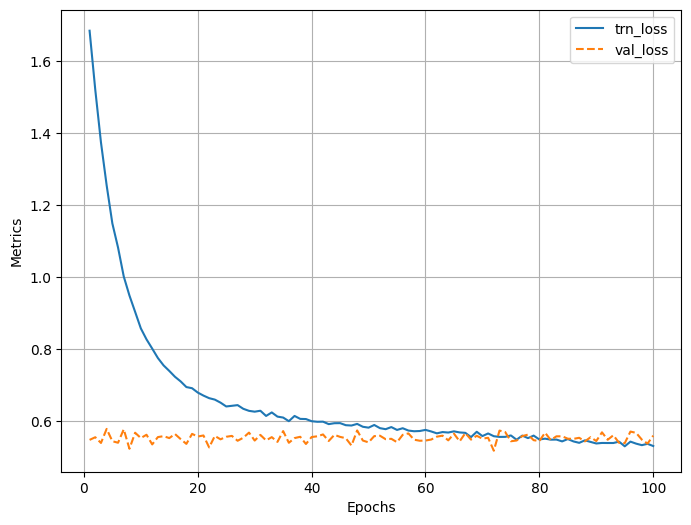

train_loss,█▆▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_loc_loss,█▇▅▄▃▃▂▃▂▃▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▃▃▁▂▁▂▁▁▁▁▂▁▁▁
trn_loss,▇█▄▅▃▄▃▃▂▄▂▃▂▂▃▃▂▂▃▂▃▃▂▁▃▂▄▅▁▃▂▂▂▁▁▁▃▁▂▁
trn_loss_objectness,▃▅▁▇▁▃▄▂▂█▂▆▂▁▂▂▅▂▄▁▅▁▄▅▃▁▃▂▂▁▁▃▁▁▁▁▃▁▂▁
trn_loss_rpn_box_reg,▁▄▂█▃▁▂▃▂▅▂▃▁▃▃▅▃▂▄▁▅▆▄▂▃▁▃▄▂▃▂▂▂▁▂▃▃▂▁▁
trn_regr_loss,▂█▃▅▃▄▃▄▁▇▂▄▃▂▄▄▃▂▄▃▄▅▃▂▄▂▇█▁▄▃▄▃▁▁▂▅▂▂▂
val_loc_loss,▁▃▄▁▁▄▁▇▃▅▅█▂▃▃▅▄▇▄▁▄▅▁▄▃▁▂▅▂▂▆▂▂▄▁▁▅▅▄▇
val_loss,▁▄▅▁▂▄▁▇▃▅▆█▂▃▂▆▃█▅▁▄▅▁▅▃▁▂▆▂▂▇▁▂▅▁▁▆▅▄█
val_loss_objectness,▁▄▁▁▁▃▁▇▁█▁▂▁▁▁▂▁▂▅▁▃▄▁▄▃▁▁▂▃▁▂▁▂▅▂▁▃▃▂▃
val_loss_rpn_box_reg,▃▆▃▁▃▆▅▂▂▆▅█▃▆▃▄▇▆▄▁▆▇▄▇▃▁▂▄▄▂▂▂▁▄▁▂▃▃▃▄
val_regr_loss,▂▄▅▂▂▄▁▇▃▅▆█▂▃▂▆▃█▄▁▄▄▁▅▃▁▂▆▁▂▇▁▂▄▁▁▆▄▄█


In [13]:
log = Report(epochs)
min_loss = 100


# Inside training loop
for e in range(epochs):
    epoch_loss = 0
    for i, batch in enumerate(tr_dl):
        N = len(tr_dl)
        loss, losses = train_batch(batch, model, optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_loss_objectness=loss_objectness.item(),
                   trn_loss_rpn_box_reg = loss_rpn_box_reg.item())
        # Log metrics with wandb
        wandb.log({
            'trn_loss': loss,
            'trn_loc_loss': loc_loss,
            'trn_regr_loss': regr_loss,
            'trn_loss_objectness': loss_objectness,
            'trn_loss_rpn_box_reg': loss_rpn_box_reg
        })
        epoch_loss += loss.item()


    epoch_loss /= len(tr_dl)
    if epoch_loss < min_loss:
        torch.save(model.state_dict(), checkpoint_file)
#        save_checkpoint(epoch=e, model=model, model_name=model_settings['backbone'], optimizer=optim, optimizer_name=model_settings['optimizer'])
    wandb.log({'train_loss': epoch_loss})
    print("Loss={0:.4f} in Epoch={1:d}".format(epoch_loss, e))

    log.report_avgs(e+1)

# validation loop
for e in range(epochs):
    # Validation loop
    for i, batch in enumerate(val_dl):
        N = len(val_dl)
        loss, losses = validate_batch(batch, model.float(), optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg',
                                                                   'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                   val_regr_loss=regr_loss.item(), val_loss_objectness=loss_objectness.item(),
                   val_loss_rpn_box_reg = loss_rpn_box_reg.item())
        # Log metrics with wandb
        wandb.log({
            'val_loss': loss,
            'val_loc_loss': loc_loss,
            'val_regr_loss': regr_loss,
            'val_loss_objectness': loss_objectness,
            'val_loss_rpn_box_reg': loss_rpn_box_reg
        })

    log.report_avgs(e+1)

log.plot_epochs(['trn_loss', 'val_loss'])
wandb.finish()

In [ ]:
from torchvision.ops import nms

def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for i, (images, targets) in enumerate(val_dl):
    if i == 10: break
    images = [im for im in images]
    outputs = model(images)
    for i, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        show(images[i].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5, text_sz=10)